# Introduction

This project shows: 
- ability to write structured code in Python. 
- ability to use existing utilities (libraries) for data processing and analysis.
- skills in data analysis and preprocessing
- data visualization
- Time series analysis

The project includes:
1. Data preprocessing:
    - Data resampling.
    - Data processing for Machine Learning models.
2. data analysis:
    - Time Series Analysis.
3. Feature Engineering:
    - Extracting additional features for Machine Learning models
4. Exploring Machine Learning Models 

Project of the training course "[Specialist in Data Science](https://practicum.yandex.com/data-scientist)" by [Yandex Practicum](https://practicum.yandex.com/).

# Setting up the project

In [1]:
%%html
<style>
table {float:left}
</style>

## Importing libraries

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
# Reading files
import os 
from pathlib import Path
import urllib
# Data analysis - trends and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
# Machine Learning models (Regression models)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
# Model evaluation - Regression metrics
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
# Sanity check
from sklearn.dummy import DummyRegressor
# Splitting data
from sklearn.model_selection import train_test_split,GridSearchCV
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Setting up matplotlib

In [3]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [4]:
# increasing the resolution
%config InlineBackend.figure_format = 'retina'

In [5]:
# disable warnigns
warnings.filterwarnings('ignore')

In [6]:
# removing exponential notation
pd.options.display.float_format = '{:.3f}'.format

# Time Series

# Project "Forecasting taxi orders"

## Project description

A company providing a taxi service needs a system for predicting the number of taxi orders for the next hour to attract more drivers during peak periods.

## Data description

Provided data - historical data: taxi orders at airports

## Task details
Company is concerned about:
- The value of the RMSE metric on the test sample should not be greater than 48.





 |Column           |Description          |Column type
 |:---------------|:------------------------|:-------------|
 |num_orders    | Number of taxi orders|target  |

## Objective
Build a model that predicts number of taxi orders in next hour.

## Work plan
1. [Overview of data](#review)
2. [Data preprocessing](#dataPreprocessing)
    - [Resample](#resample)
    - [Data check](#dataCheck)
3. [Data analysis](#dataAnalysis)
    - [Moving average](#movingAverage)
    - [Trend](#trend)
    - [Seasonality](#seasonal)
4. [Feature Engineering](#featureEngineering)
5. [Machine Learning model research](#MLmodelResearch)
6. [Research results](#resultsRearchModel)
7. [Results](#results)

<a id="review"></a>
# Stage 1 - Overview of data

Reading the data and saving it in appropriate variable.

In [7]:
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    # Check if there is a file
    if not os.path.exists(file_name):
        print(file_name,'cannot find file, file will be downloaded from URL link')
        # download the file from the url link, put it in the path file_name
        # load data using the urllib library
        _ = urllib.request.urlretrieve(url, file_name)

# Dictionary with the file name and a URL link to it
urls = {
    'taxi': ('datasets/taxi.csv', '_______________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

raw_taxi = pd.read_csv(urls['taxi'][0],sep=',', index_col=[0], parse_dates=[0])

Let's look at our data. Display the first 10 lines.

In [8]:
raw_taxi.head(10)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12

Note that the interval between the values of the series: **10 minutes**

Let's check if the dates and times are in chronological order using the *is_monotonic* table index attribute

In [9]:
if(raw_taxi.index.is_monotonic):
    print('Data in chronological order')
else:
    print('The order is not respected')

Data in chronological order


Great, data in chronological order.

Display general info

In [10]:
raw_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


There are 26496 objects, 1 column with type *int64*. There are no missing values. We were given data from March 2018 to August 2018.

In [11]:
raw_taxi.describe()

num_orders
count   26496.000
mean       14.070
std         9.211
min         0.000
25%         8.000
50%        13.000
75%        19.000
max       119.000

The maximum number of orders during this period was 119 orders in 10 minutes.

Build the graph

First, let's write a function for the display of time series graphs

In [12]:
def timeSeriesPlot(df, title, xlabel, ylabel):
    sns.lineplot(data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

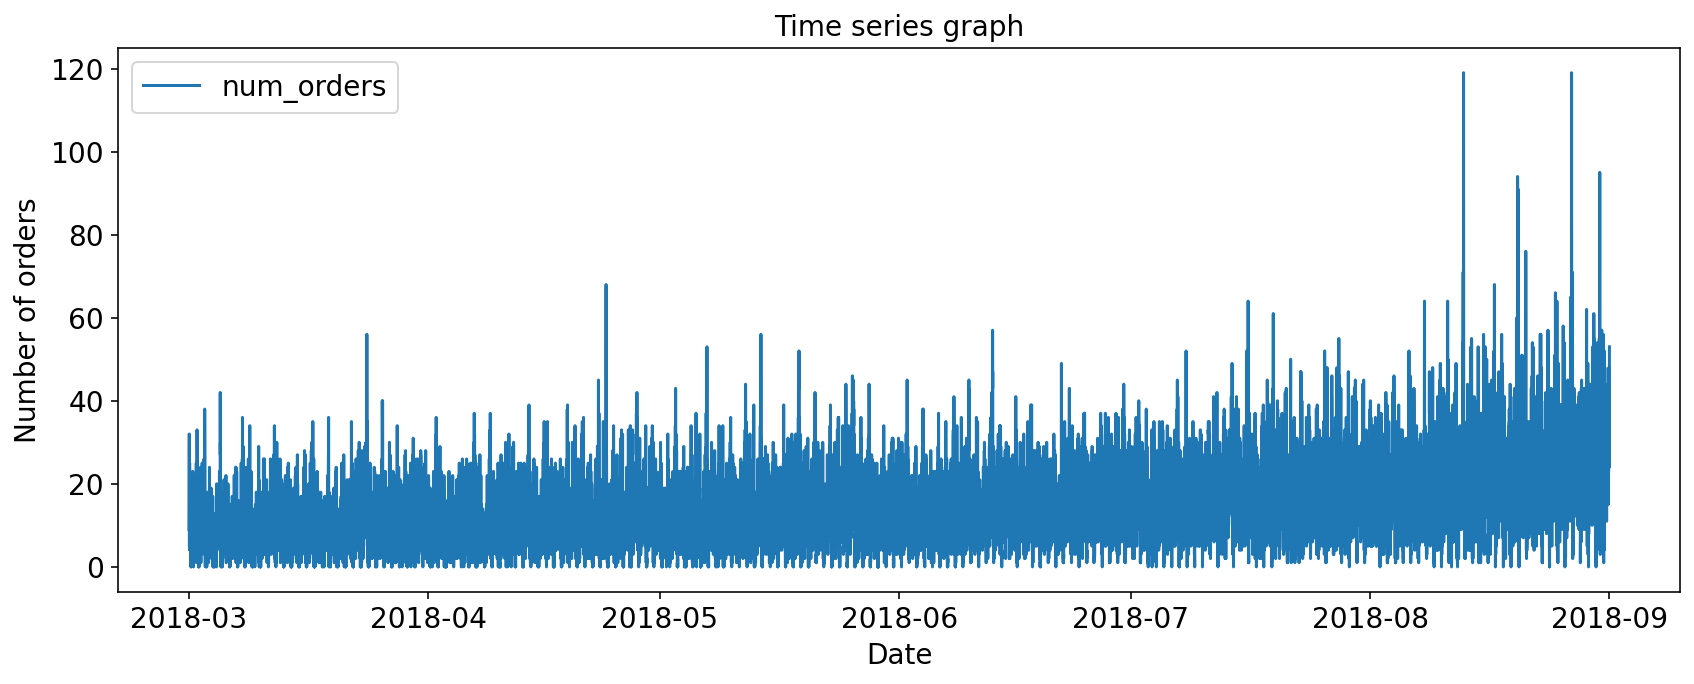

In [13]:
timeSeriesPlot(raw_taxi,'Time series graph',"Date","Number of orders")

We need to do resampling. 

## Summary

In dataframe - there are 26496 objects, 1 column with type int64. There are no missing values. We were given data from March 2018 to August 2018. the interval between the values of the series: **10 minutes**. Data is in chronological order. We need to:
1. Preprocess data:
    - resample
2. Analyze data
3. Conduct Machine Learning model research
    - find the model with the best RMSE metric on the test sample.

<br>

<a id="dataPreprocessing"></a>
# Stage 2 - Data preprocessing

We need to do resampling

<a id="resample"></a>
## Resampling

Let's resample the data by one hour and calculate the total orders

In [14]:
raw_taxi_resampled = raw_taxi.resample('1H').sum()

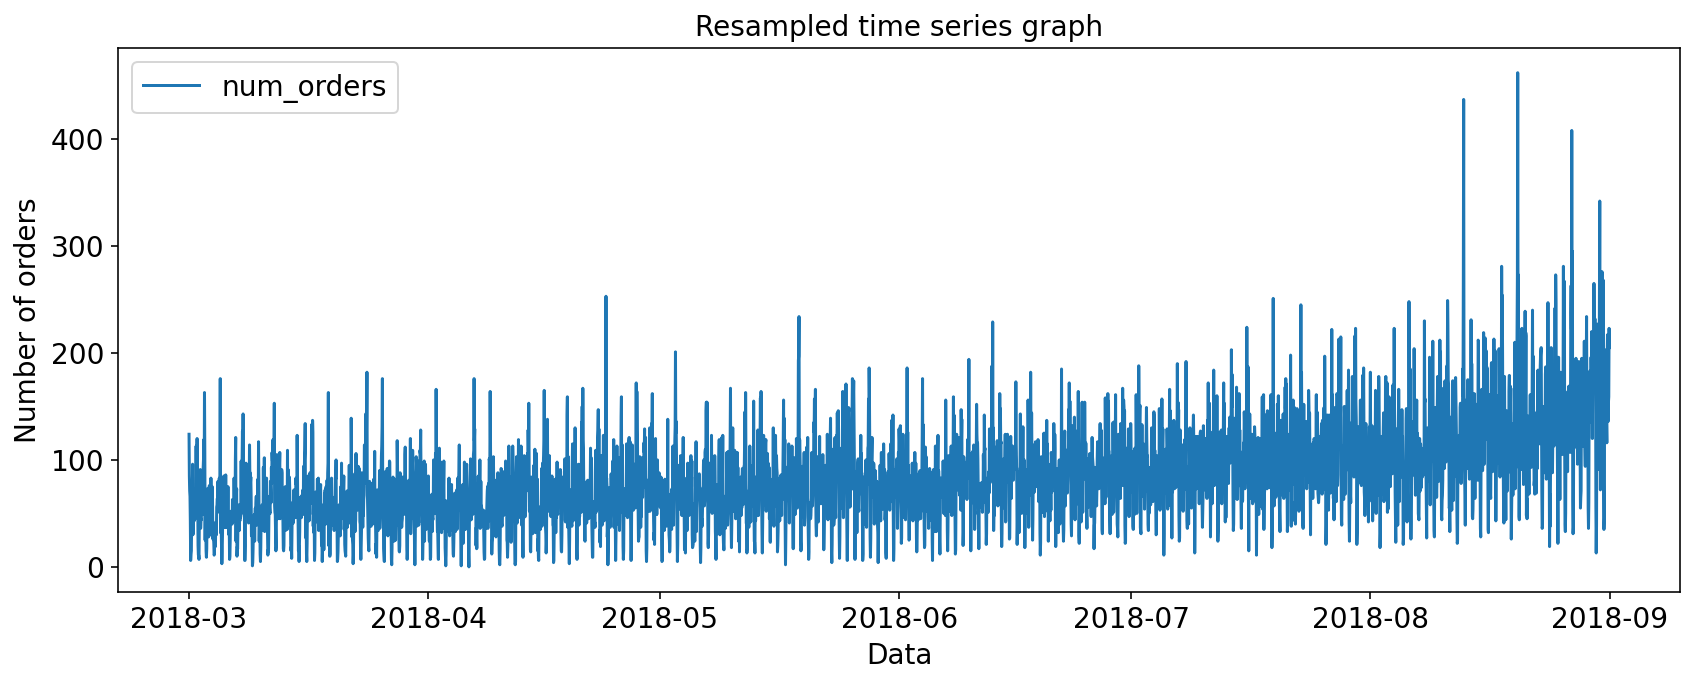

In [15]:
timeSeriesPlot(raw_taxi_resampled,'Resampled time series graph',"Data","Number of orders")

<a id="dataCheck"></a>
## Data check

Write a function which:
1. Check for missing data
2. Check appropriate types: int64

In [16]:
def get_preprocessed_data(raw_data):
    """
    Function checks dataframe. Returns preprocessed data for model training 
    raw_data - data to check
    """
    # check data
    assert raw_data.isna().sum().sum() == 0, 'There should not be missing data!'
    assert raw_data.select_dtypes(exclude=[np.int64]).size == 0, 'Type of data needs to be int64!'
    print('Data is valid!')
    # creating a copy of a data
    preprocessed_data = raw_data.copy()
    
    return preprocessed_data

In [17]:
taxi = get_preprocessed_data(raw_taxi_resampled)

Data is valid!


## Summary

We resampled the data by one hour at a time. The data passed the final check. Let's move on to Time Series analysis.

<a id="dataAnalysis"></a>
# Stage 3 - Data analysis

At this stage we need to analyze the data. Identify trends and seasonality. We will also find the moving average.

<a id="movingAverage"></a>
## Moving average

To smooth out the time series, we will use a moving average. 

Let's write a function to display the moving average

In [18]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

By smoothing the time series, we can determine trends. The wider the window, the smoother the trend

Let's take the window - 24h - daily trend. 

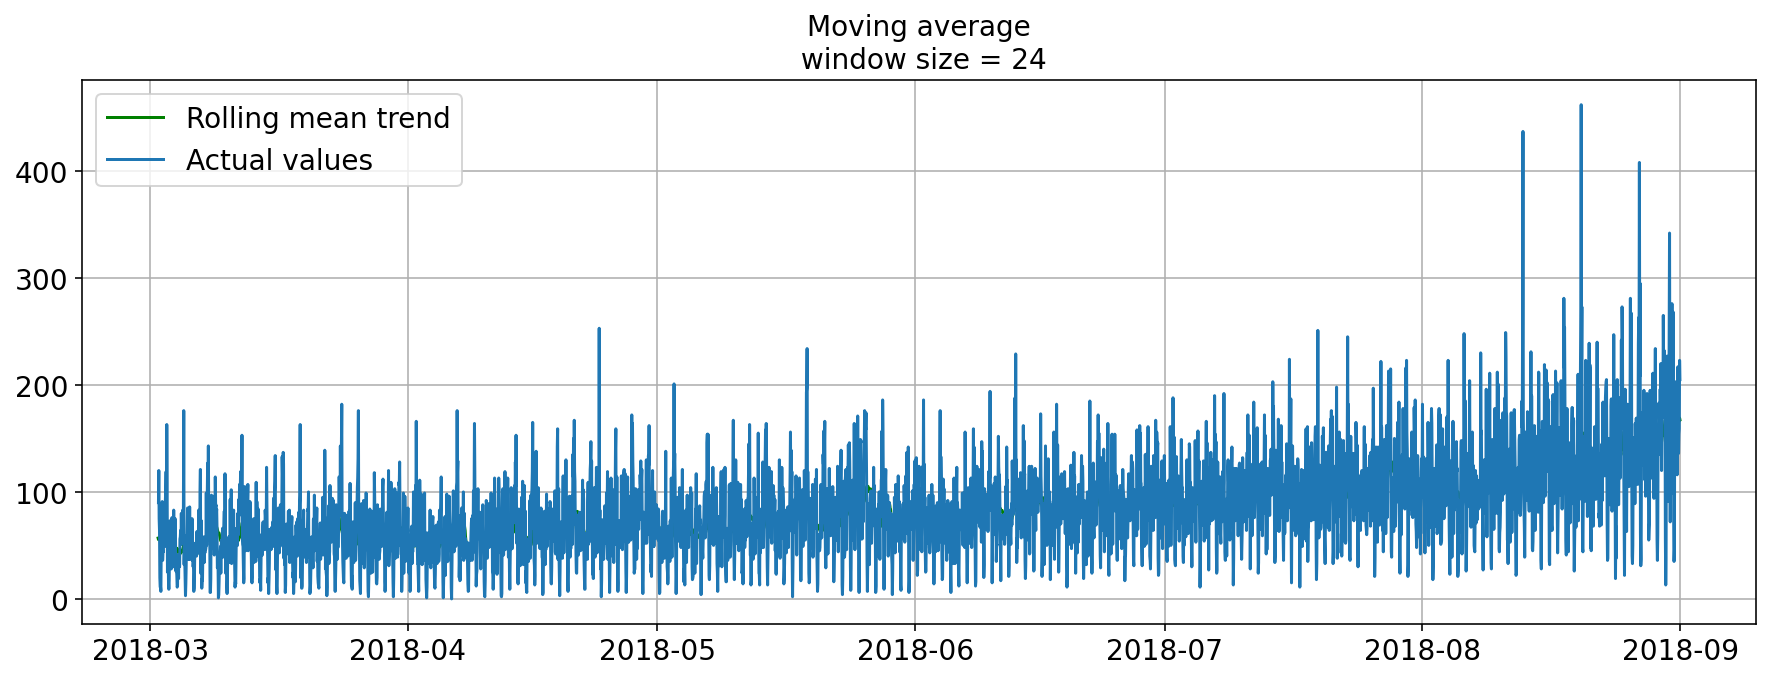

In [19]:
plotMovingAverage(taxi, 24)

A lot of noise, let's resample by day and look at the trend

In [20]:
taxi_daily = taxi.resample('1D').sum()

Let's look at the weekly trend

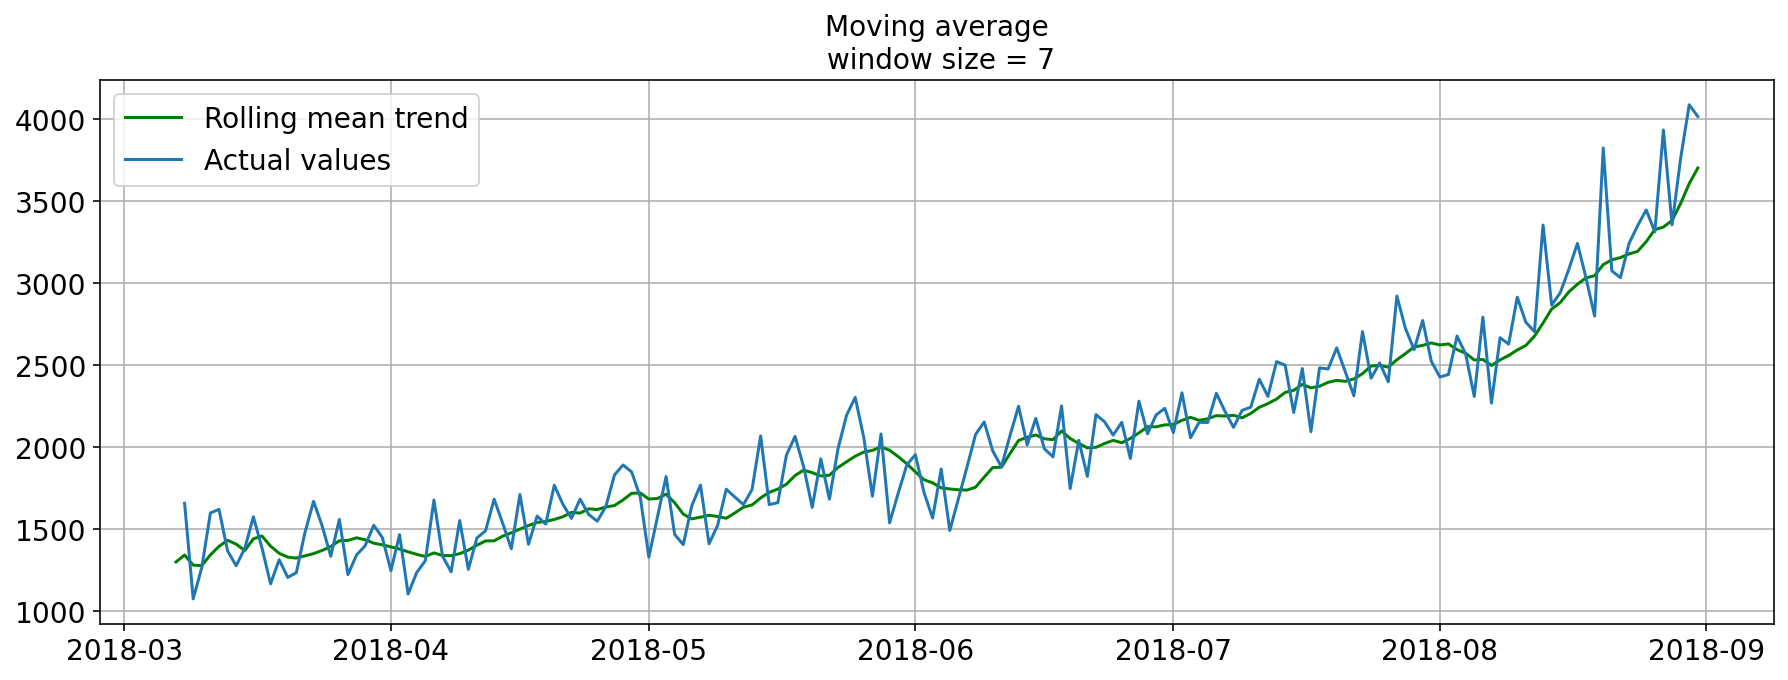

In [21]:
plotMovingAverage(taxi_daily, 7)

Let's display the confidence intervals

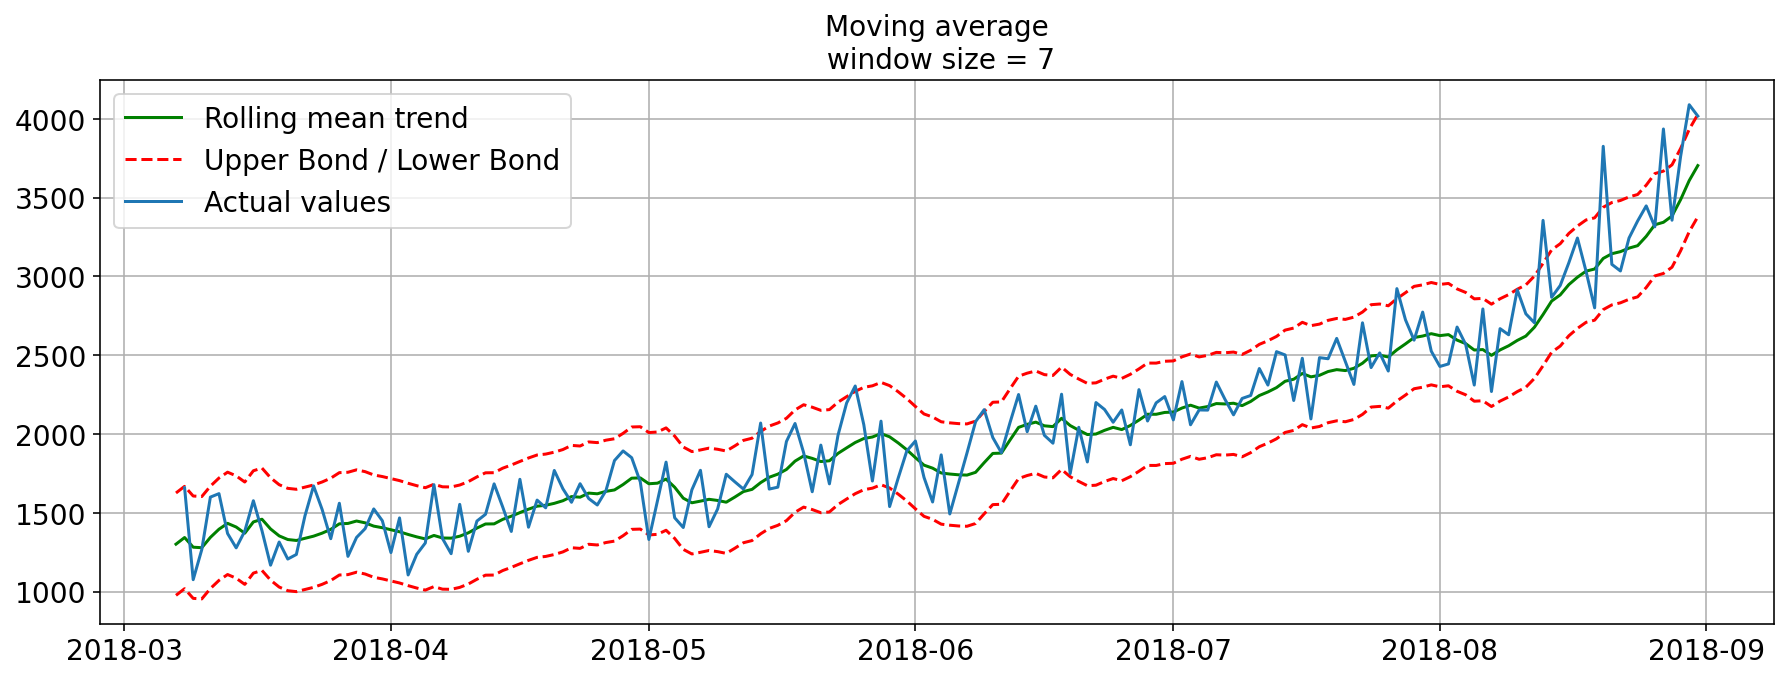

In [22]:
plotMovingAverage(taxi_daily, 7, True, True)

No abnormal values were found.

Let's take the sample for the first month, and the last month 

In [23]:
march = taxi['2018-03-01': '2018-03-31']

In [24]:
august = taxi['2018-08-01': '2018-08-31']

## First month

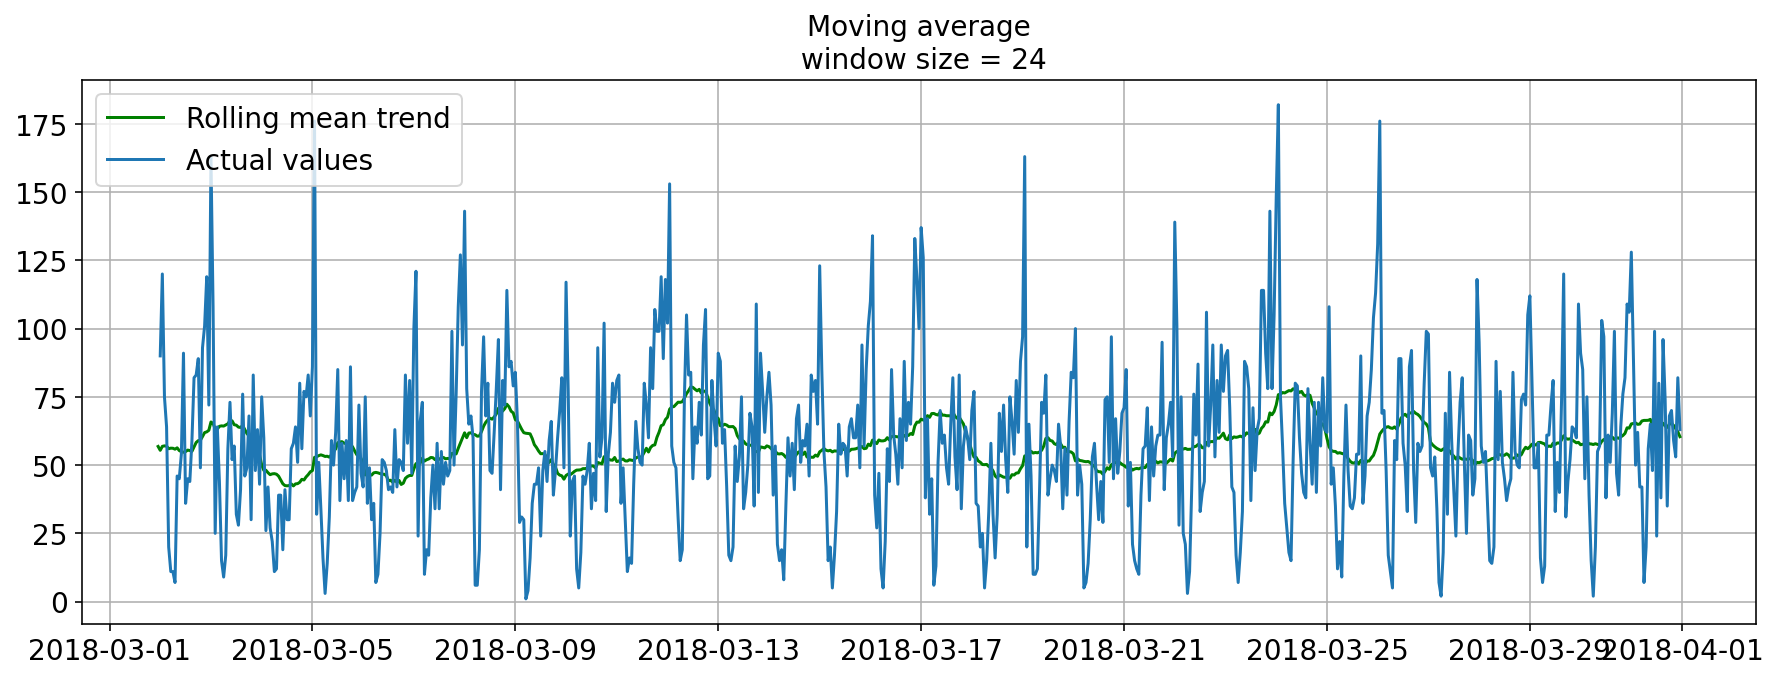

In [25]:
plotMovingAverage(march, 24)

In the first month, the moving average ranged from 45 to 75 orders per day

Take the first and last week of March

In [26]:
march_first_week = march['2018-03-01':'2018-03-07']
march_last_week = march['2018-03-24':'2018-03-31']

### First week

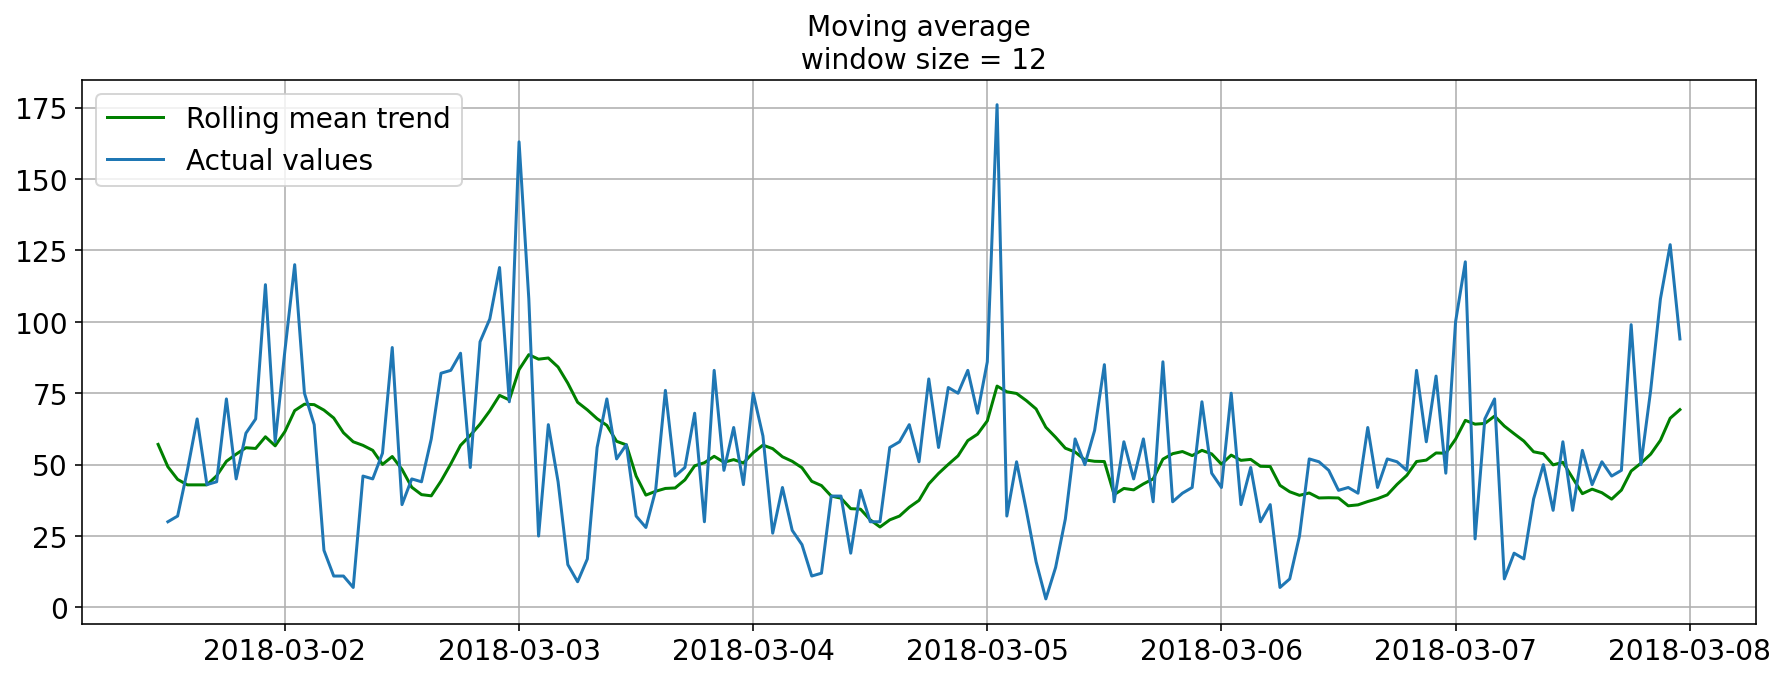

In [27]:
plotMovingAverage(march_first_week, 12)

In the first week of March, we may see a prevailing number of orders on Saturday and Monday. Will we see the same in the last week of March?

Let's look at Saturday and Monday

In [28]:
march_first_week_saturday = march_first_week['2018-03-03']
march_first_week_monday = march_first_week['2018-03-05']

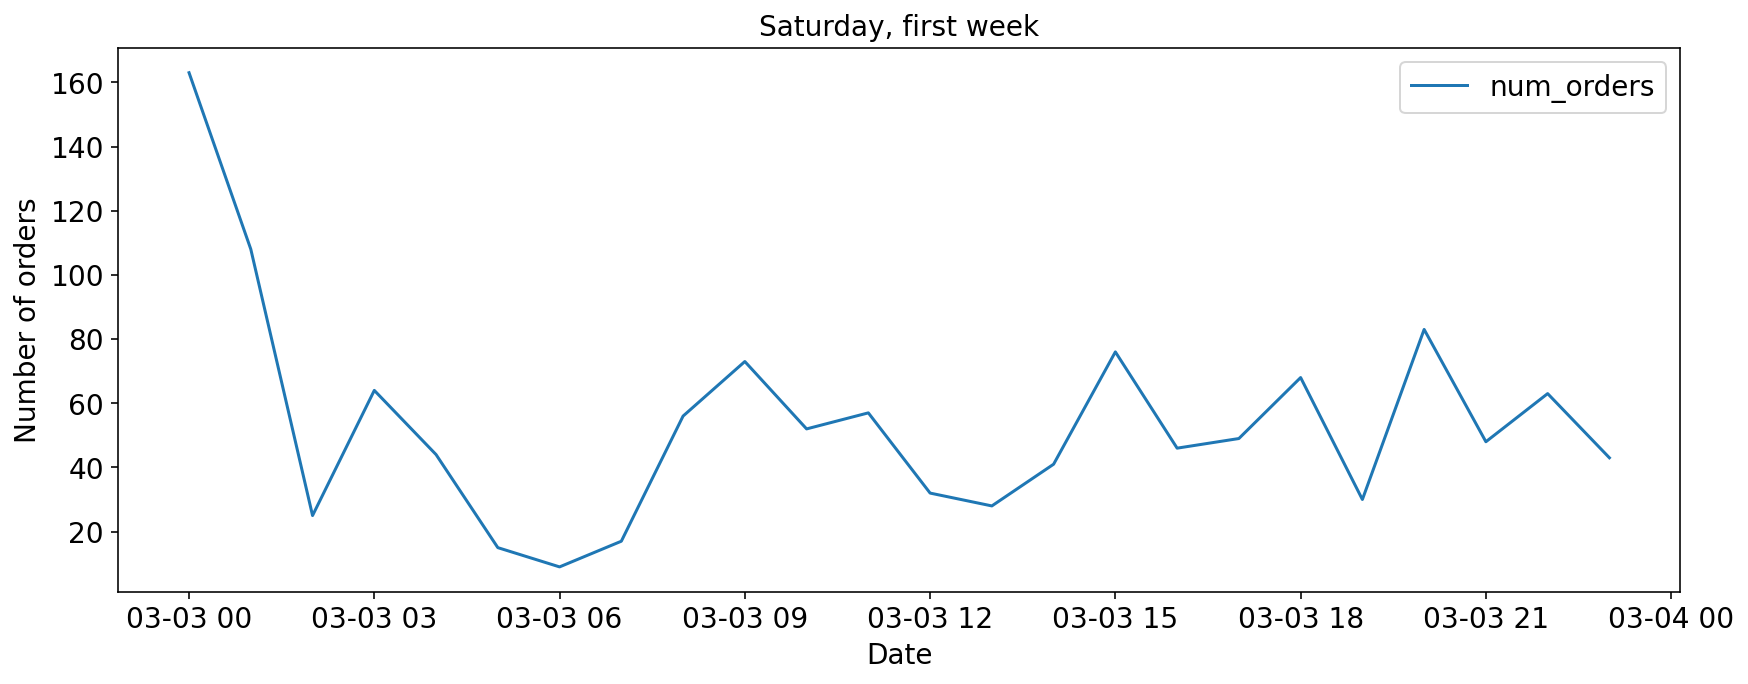

In [29]:
timeSeriesPlot(march_first_week_saturday,'Saturday, first week',"Date","Number of orders")

Most orders were at midnight. Also, we see the number of orders increase in the morning at 9:00 am, 3:00 pm, and 8:00 pm.

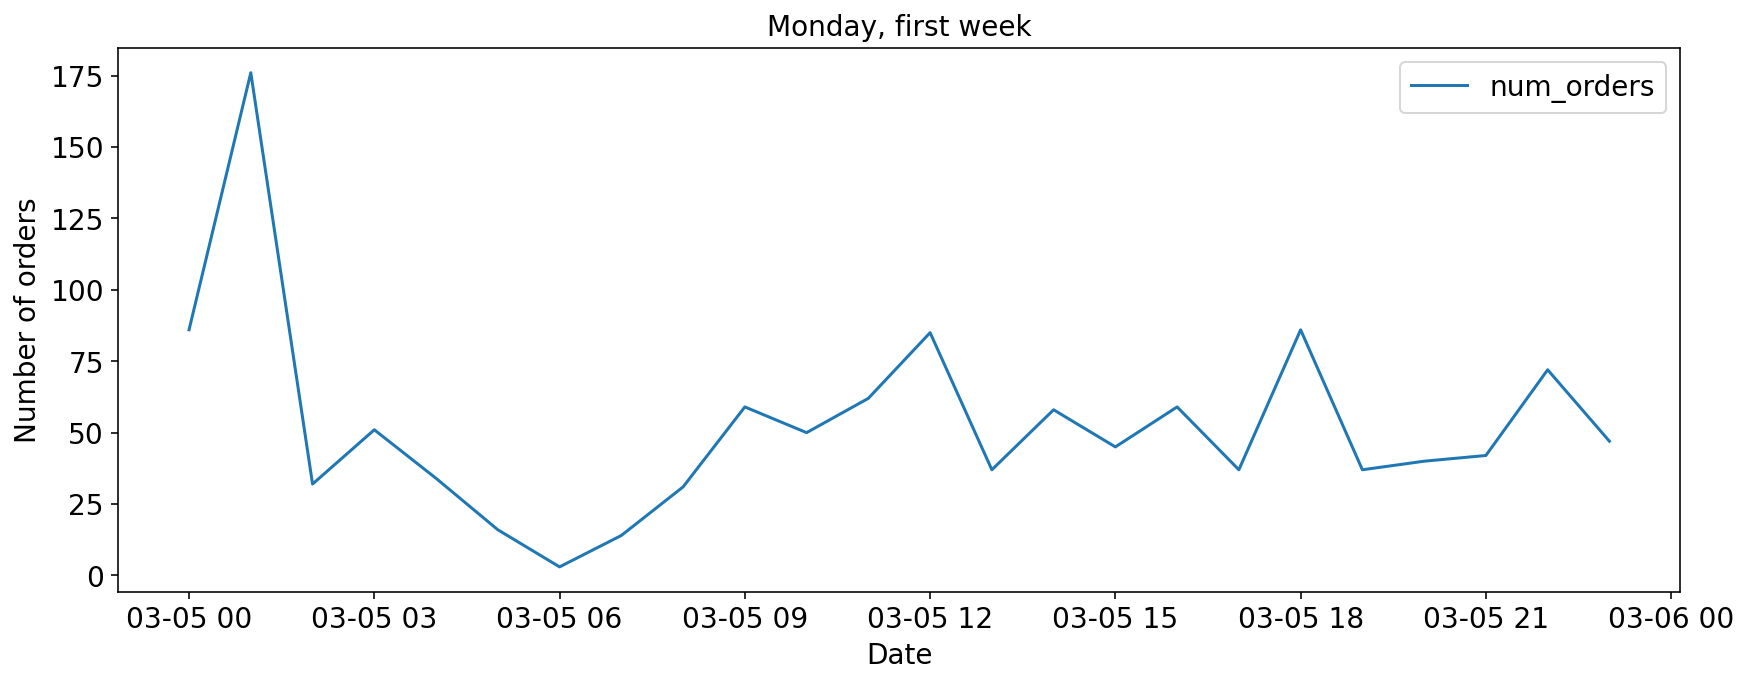

In [30]:
timeSeriesPlot(march_first_week_monday,'Monday, first week',"Date","Number of orders")

We also see a surge of orders at midnight. It turns out that cabs use more at night? The number of orders increases at 12:00 pm, 6:00 pm.

### Last week

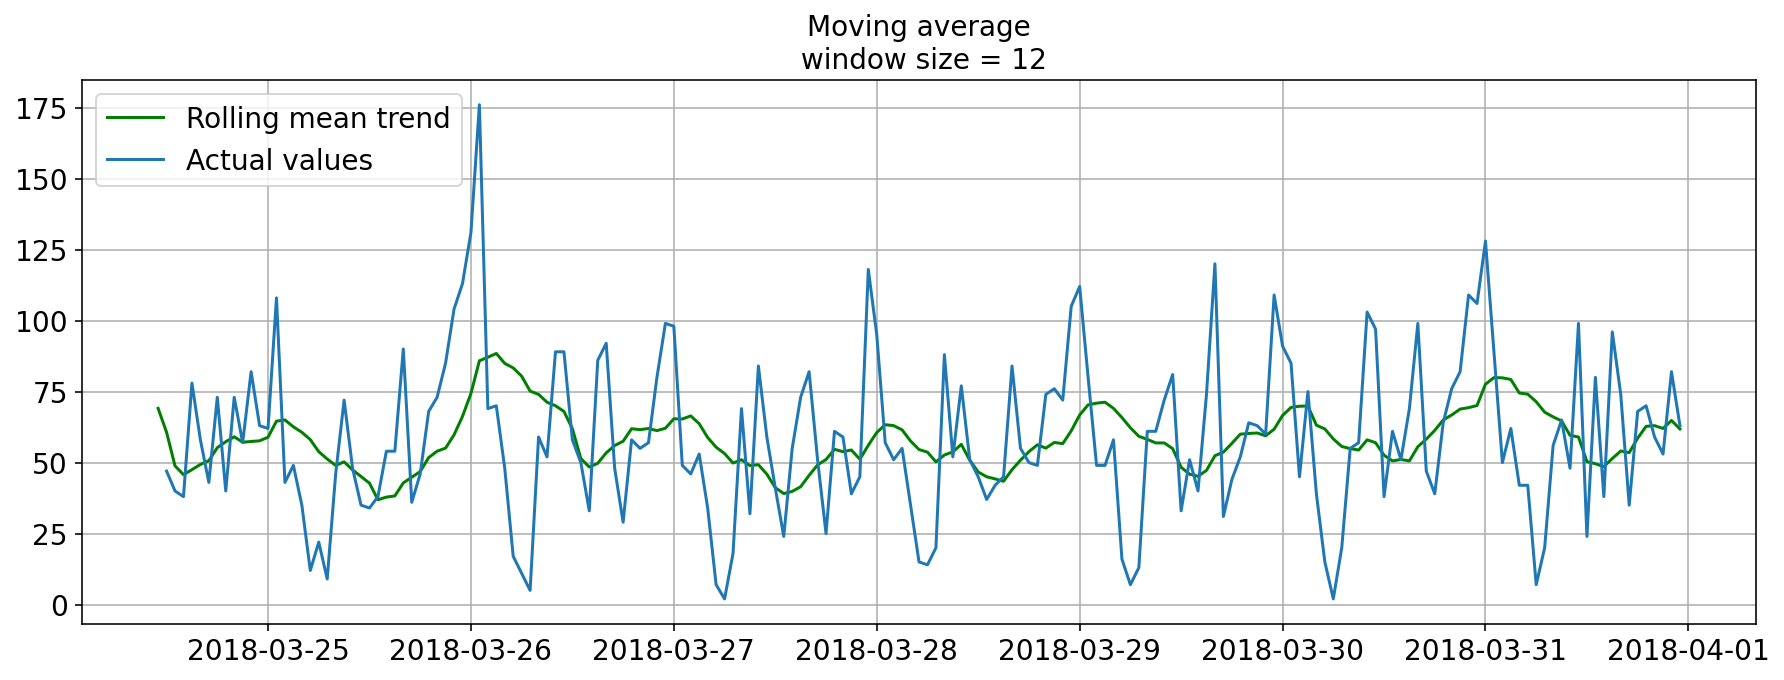

In [31]:
plotMovingAverage(march_last_week, 12)

A large number of orders are placed on Mondays. 

In [32]:
march_last_week_monday = march_last_week['2018-03-26']

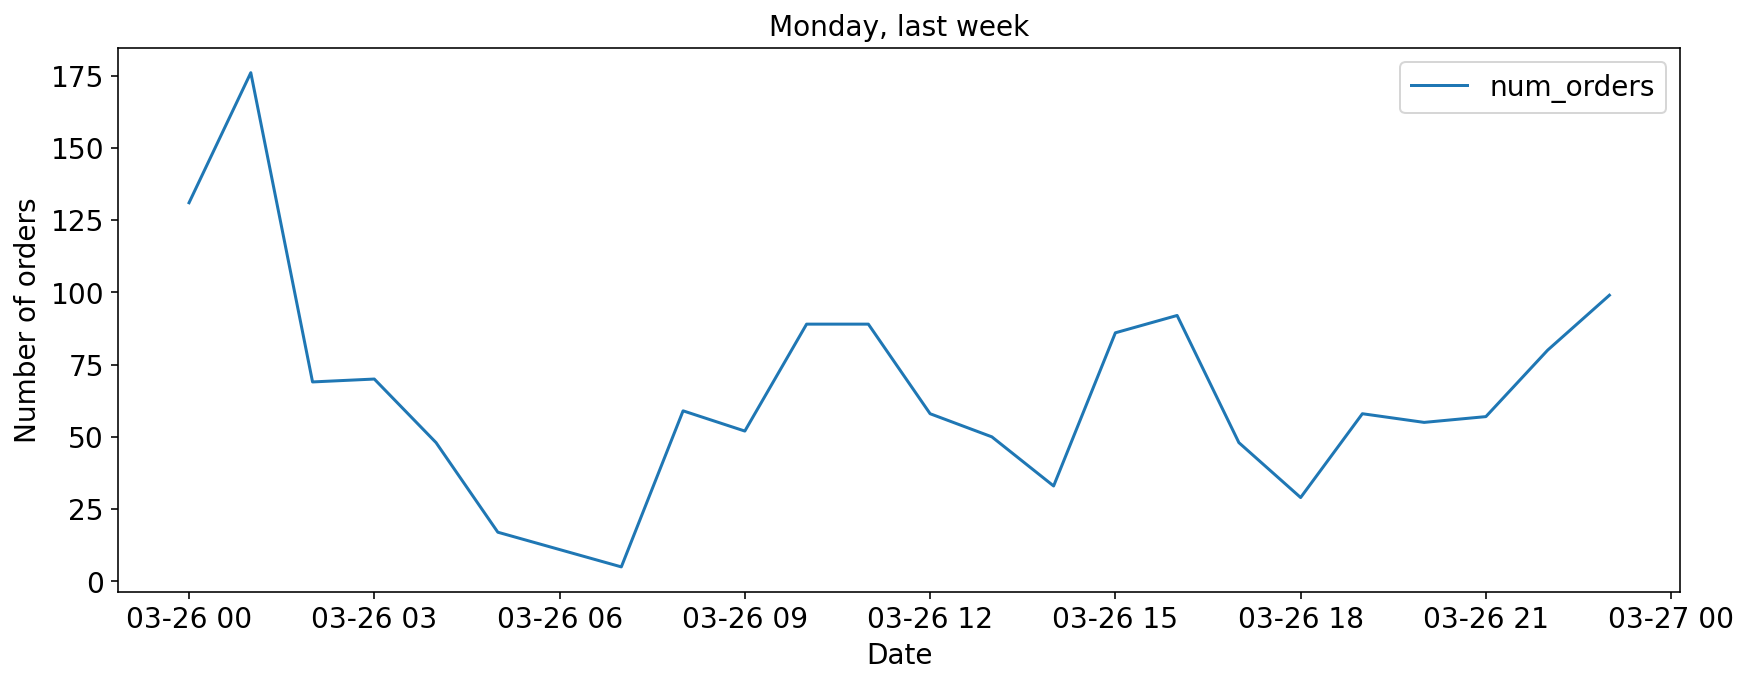

In [33]:
timeSeriesPlot(march_last_week_monday,'Monday, last week',"Date","Number of orders")

Yes, apparently some kind of trend - to order a taxi at night. The number of orders increases at 10:00-11:00 am, 3:00-16:00 pm, and 10:00-23:00 pm.

## Last month

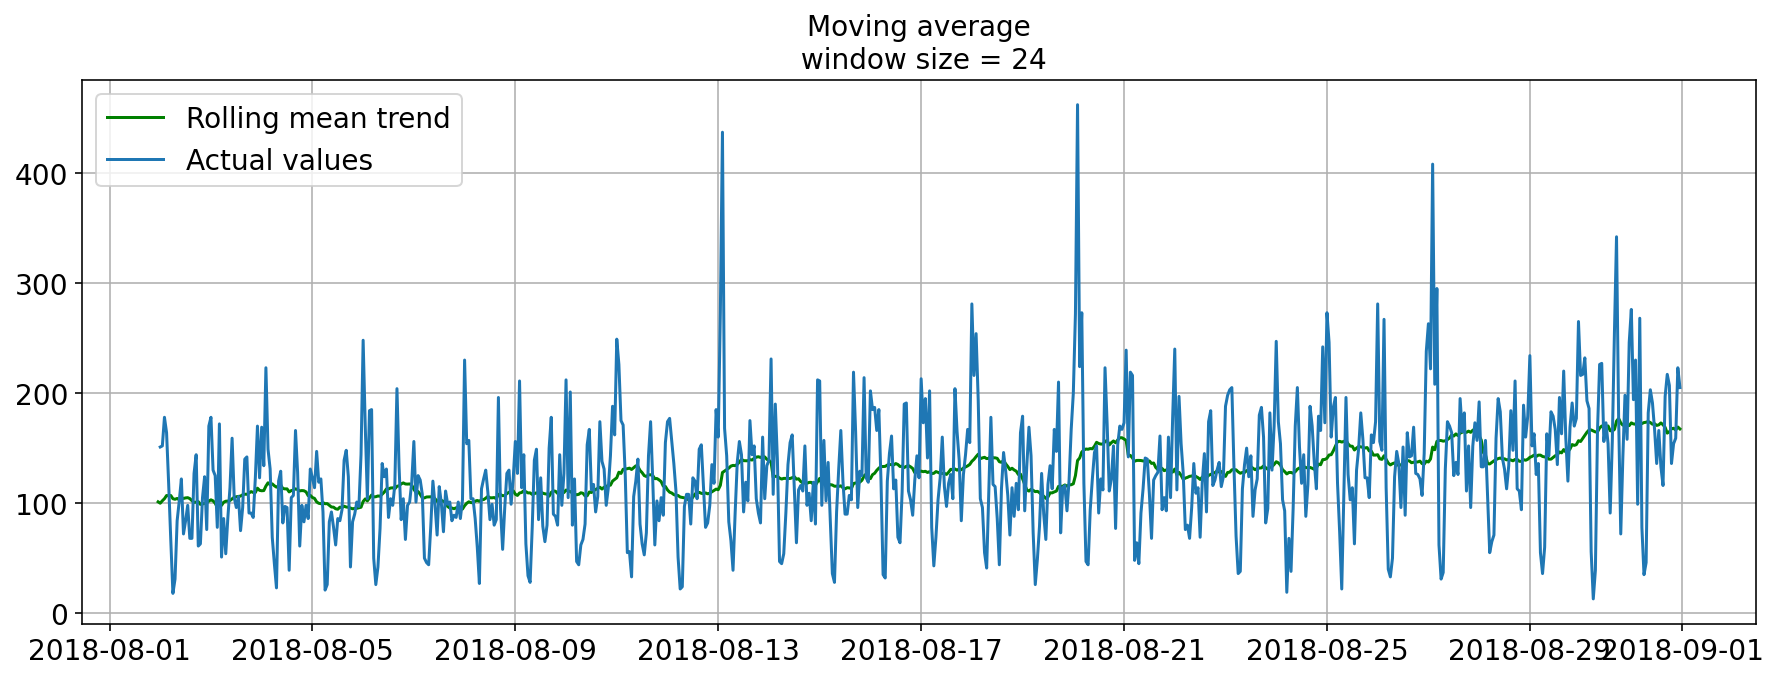

In [34]:
plotMovingAverage(august, 24)

As you can see, the range of the moving average increased from 100 to 200 orders per day.

Take the first and last week of August

In [35]:
august_first_week = august['2018-08-01':'2018-08-07']
august_last_week = august['2018-08-24':'2018-08-31']

### First week

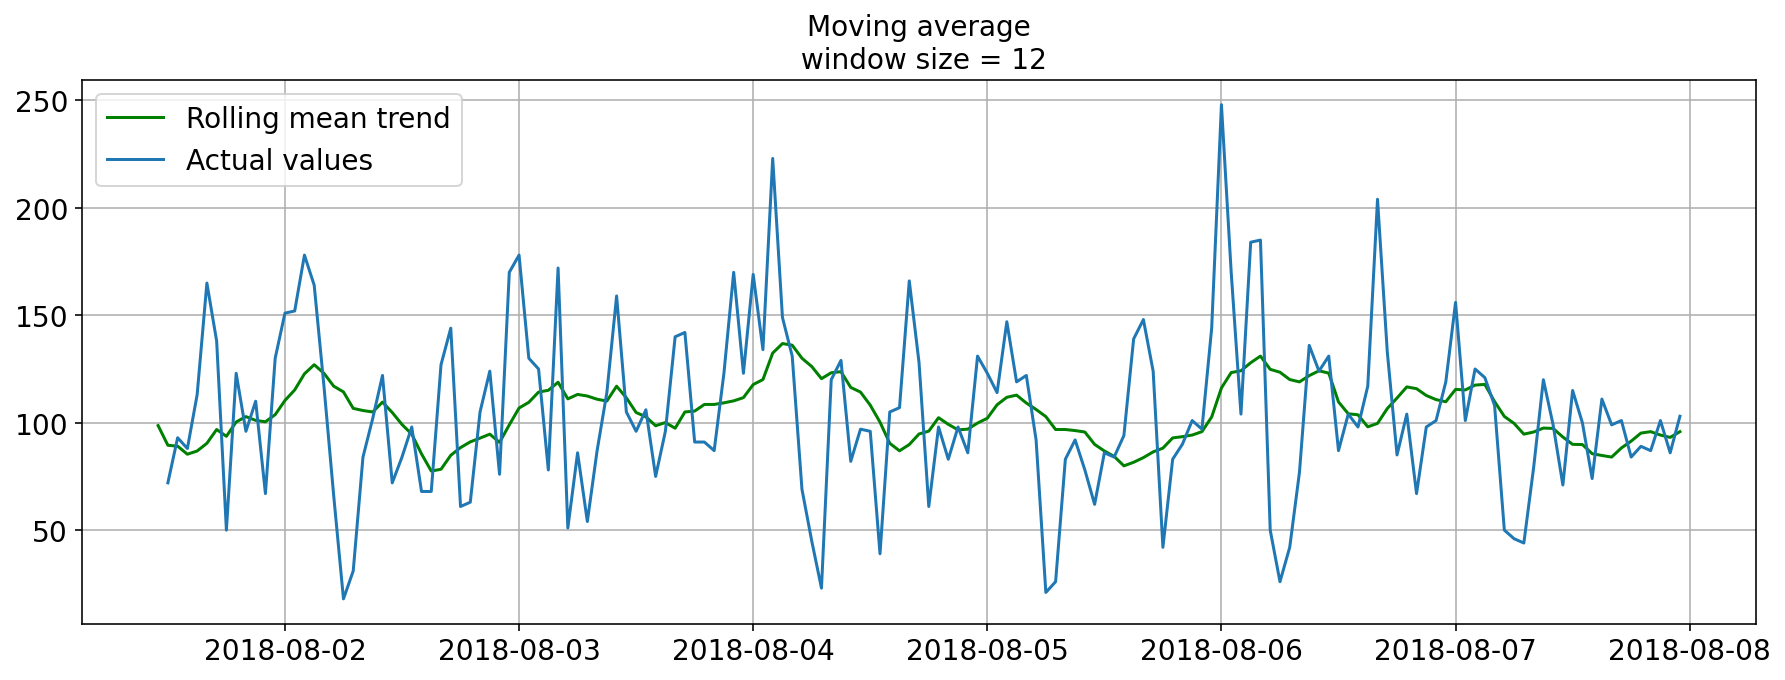

In [36]:
plotMovingAverage(august_first_week, 12)

We see a surge of orders on Saturday and Monday. Let's see if the same thing happens last week, shall we?

Let's look at Saturday and Monday.

In [37]:
august_first_week_saturday = march['2018-03-04']
august_first_week_monday = march['2018-03-06']

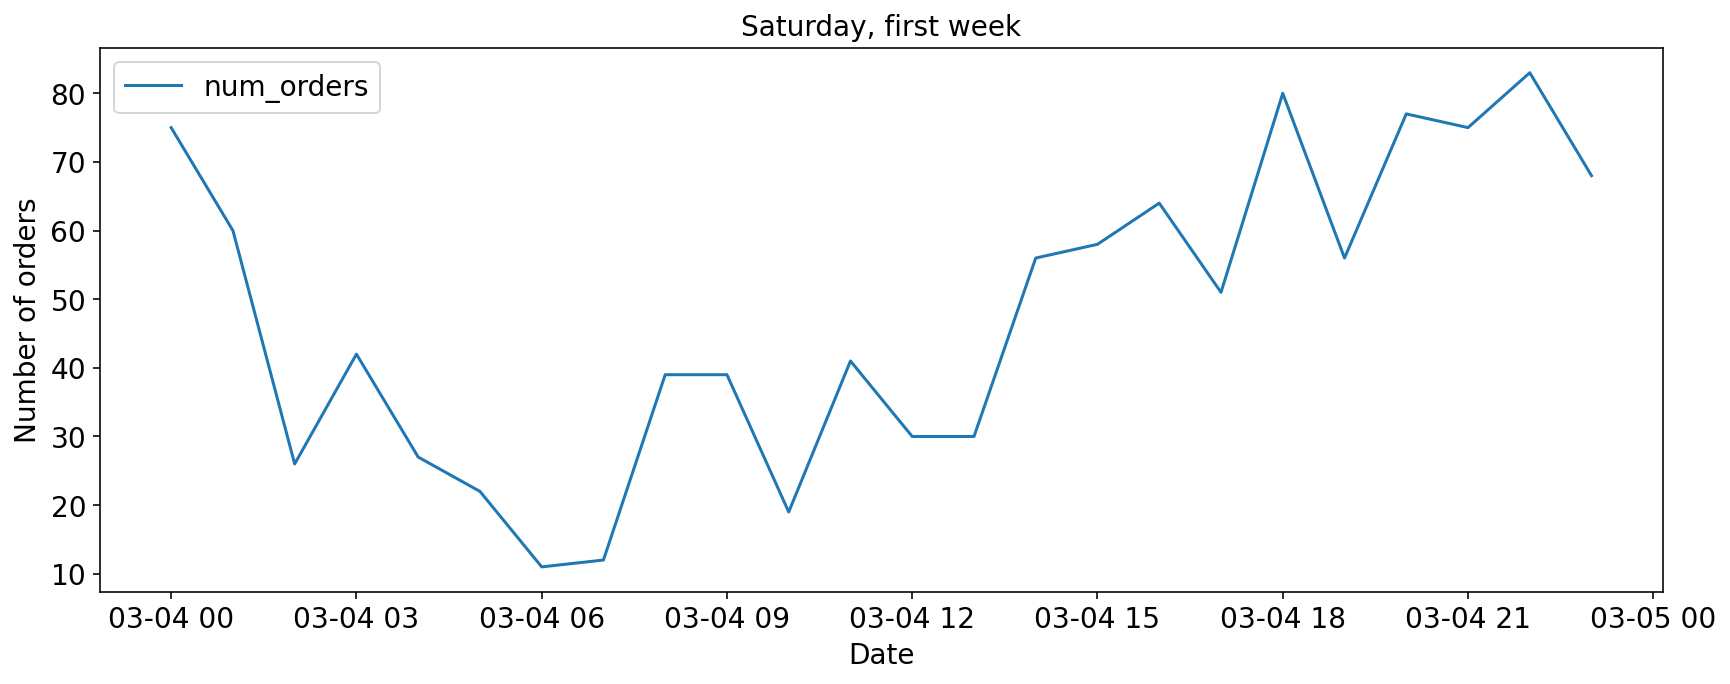

In [38]:
timeSeriesPlot(august_first_week_saturday,'Saturday, first week',"Date","Number of orders")

Wow, see the number of orders increase in the evening. 

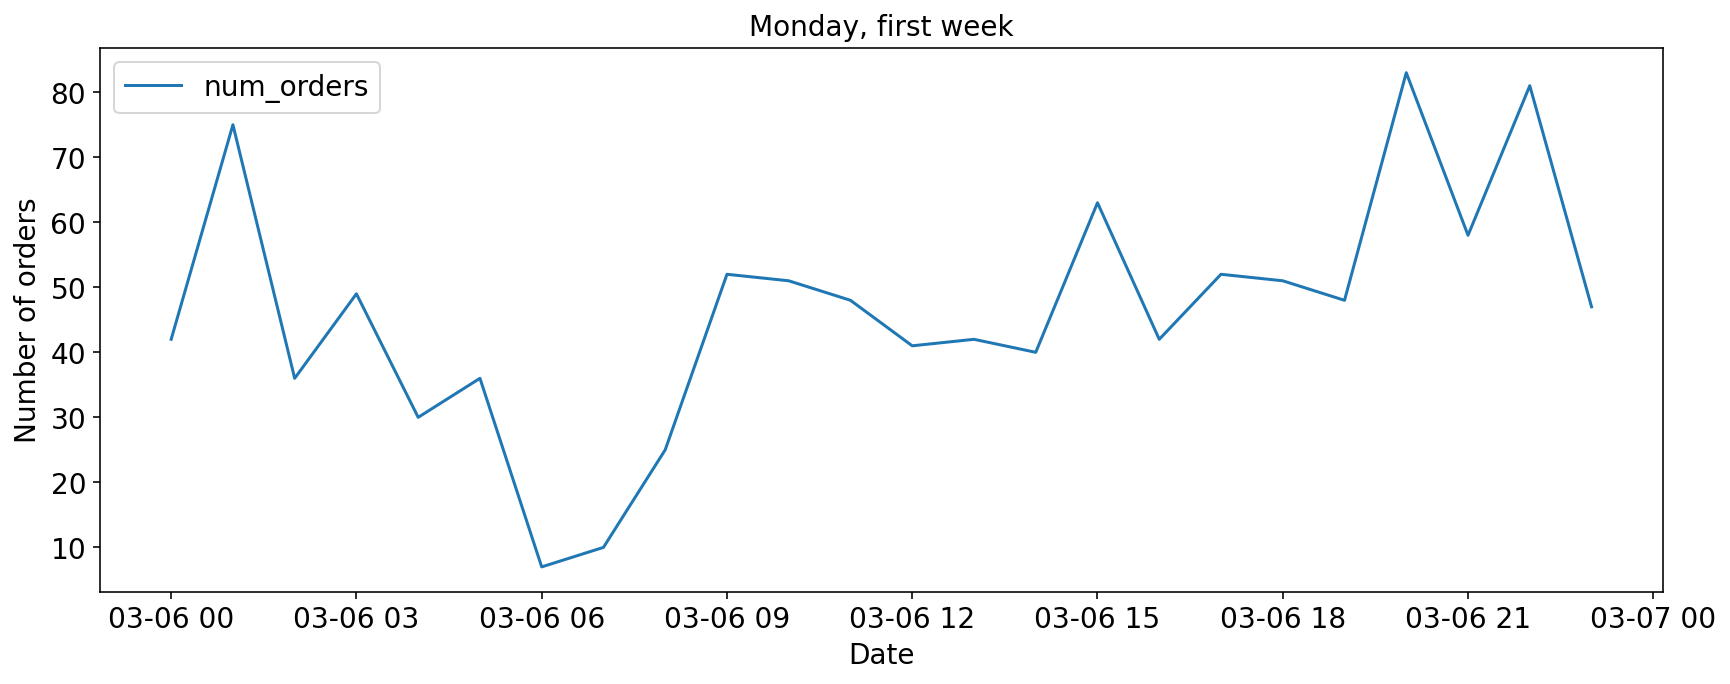

In [39]:
timeSeriesPlot(august_first_week_monday,'Monday, first week',"Date","Number of orders")

The same situation we see on Monday.

### Last week

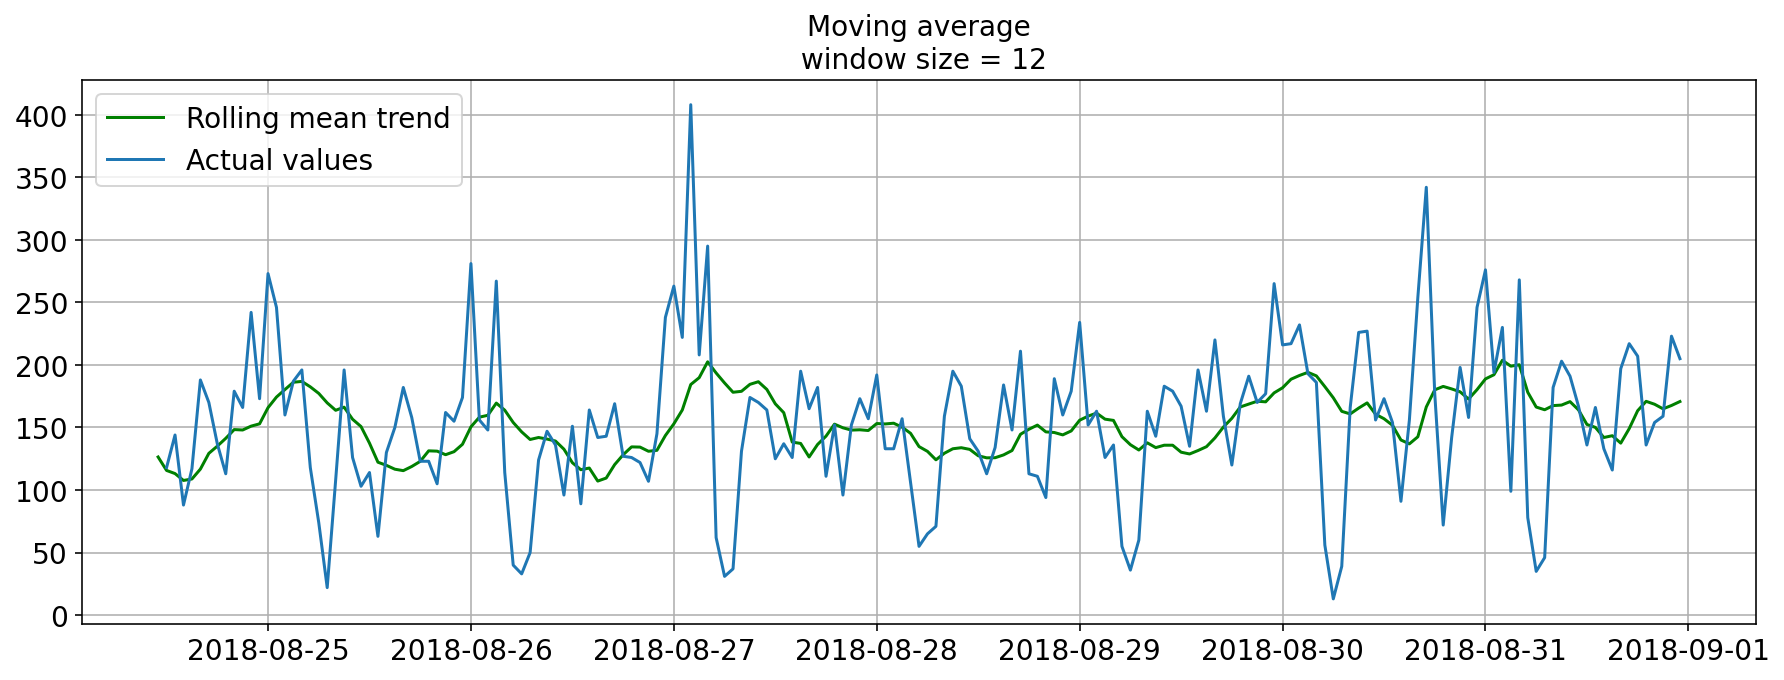

In [40]:
plotMovingAverage(august_last_week, 12)

A large number of orders are placed on Mondays.

In [41]:
august_last_week_monday = march['2018-03-27']

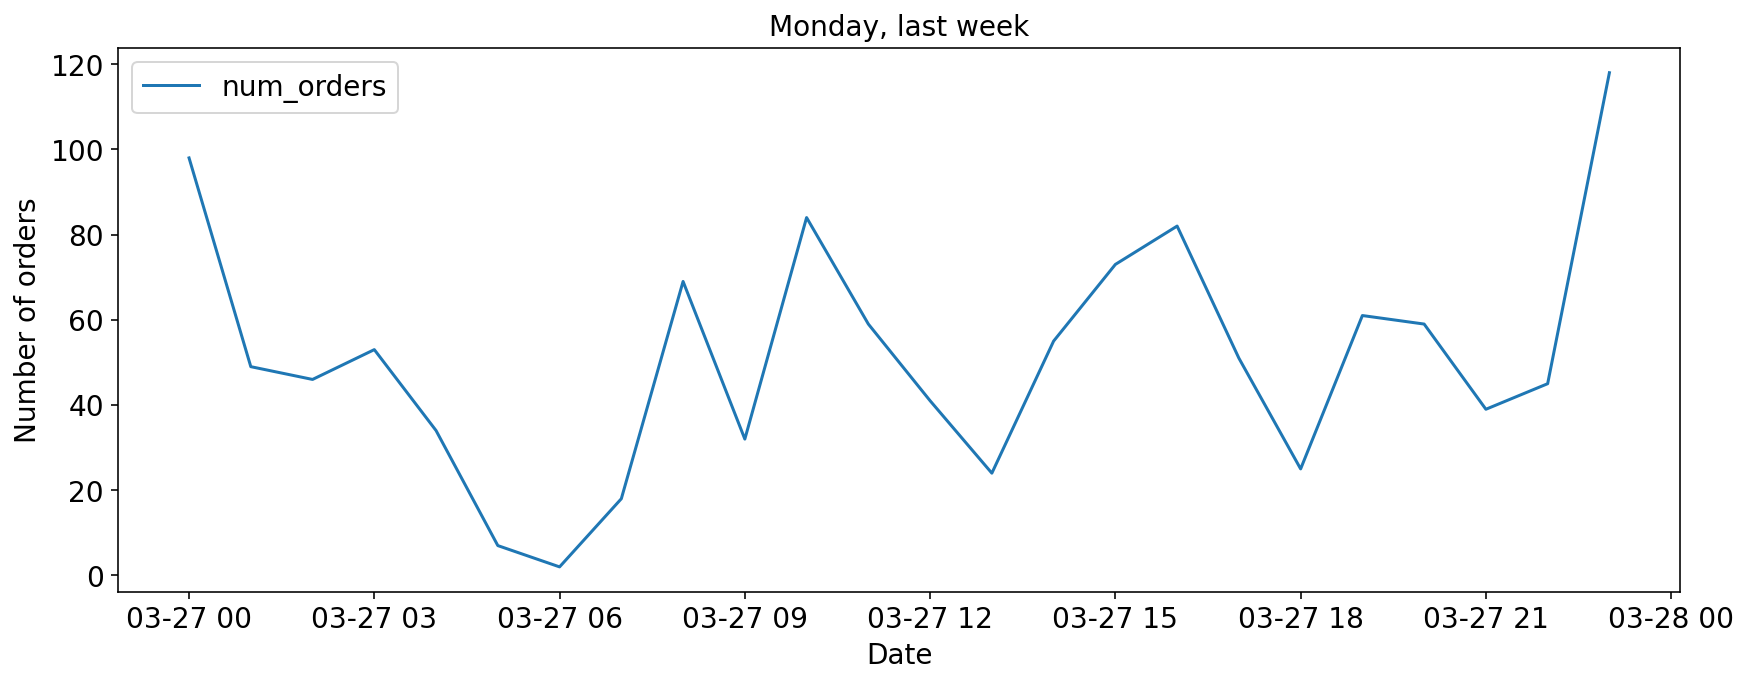

In [42]:
timeSeriesPlot(august_last_week_monday,'Monday, last week',"Date","Number of orders")

Here you can see that people use taxi in the morning 09:00-10:00 hours, at lunch (14:00-15:00), and in the evening 22:00-23:00

Looking at the data for the first and last month, I have a hypothesis: taxi are often used in the evening ,and at night and afternoon: Monday and Saturday.

Let's move on to trends

<a id="trend"></a>
## Trend

Let's use the seasonal_components() method of the statsmodels library

In [43]:
decomposed = seasonal_decompose(taxi_daily)

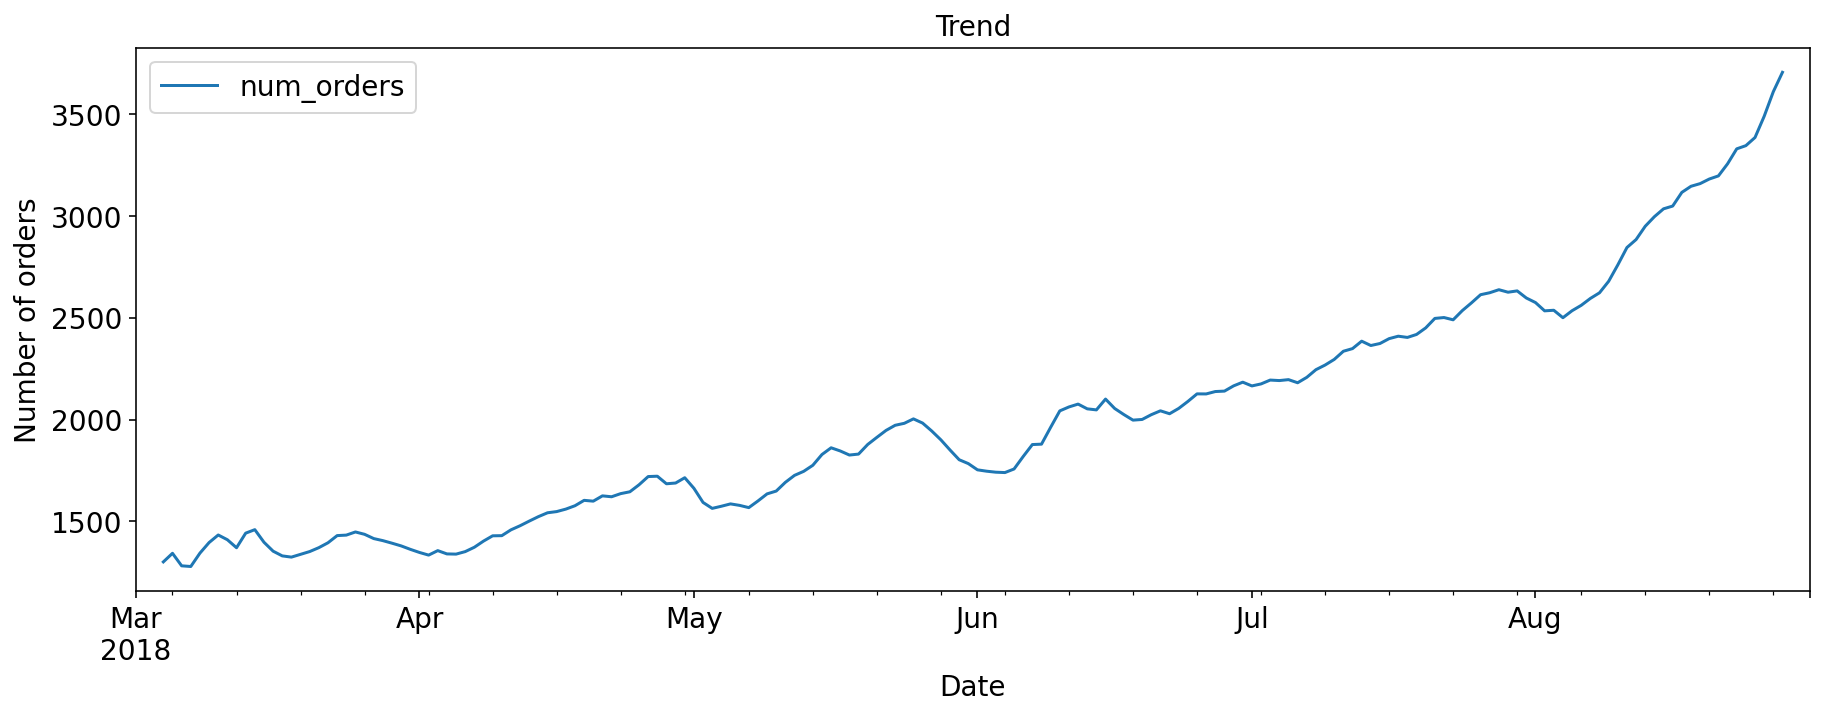

In [44]:
plt.figure(figsize=(15, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel("Date")
plt.ylabel("Number of orders")
plt.show()

We see that our number of taxi orders is increasing. However, it is hard to see if we have a monthly trend, since we have data in short period of time.

<a id="seasonal"></a>
## Seasonality

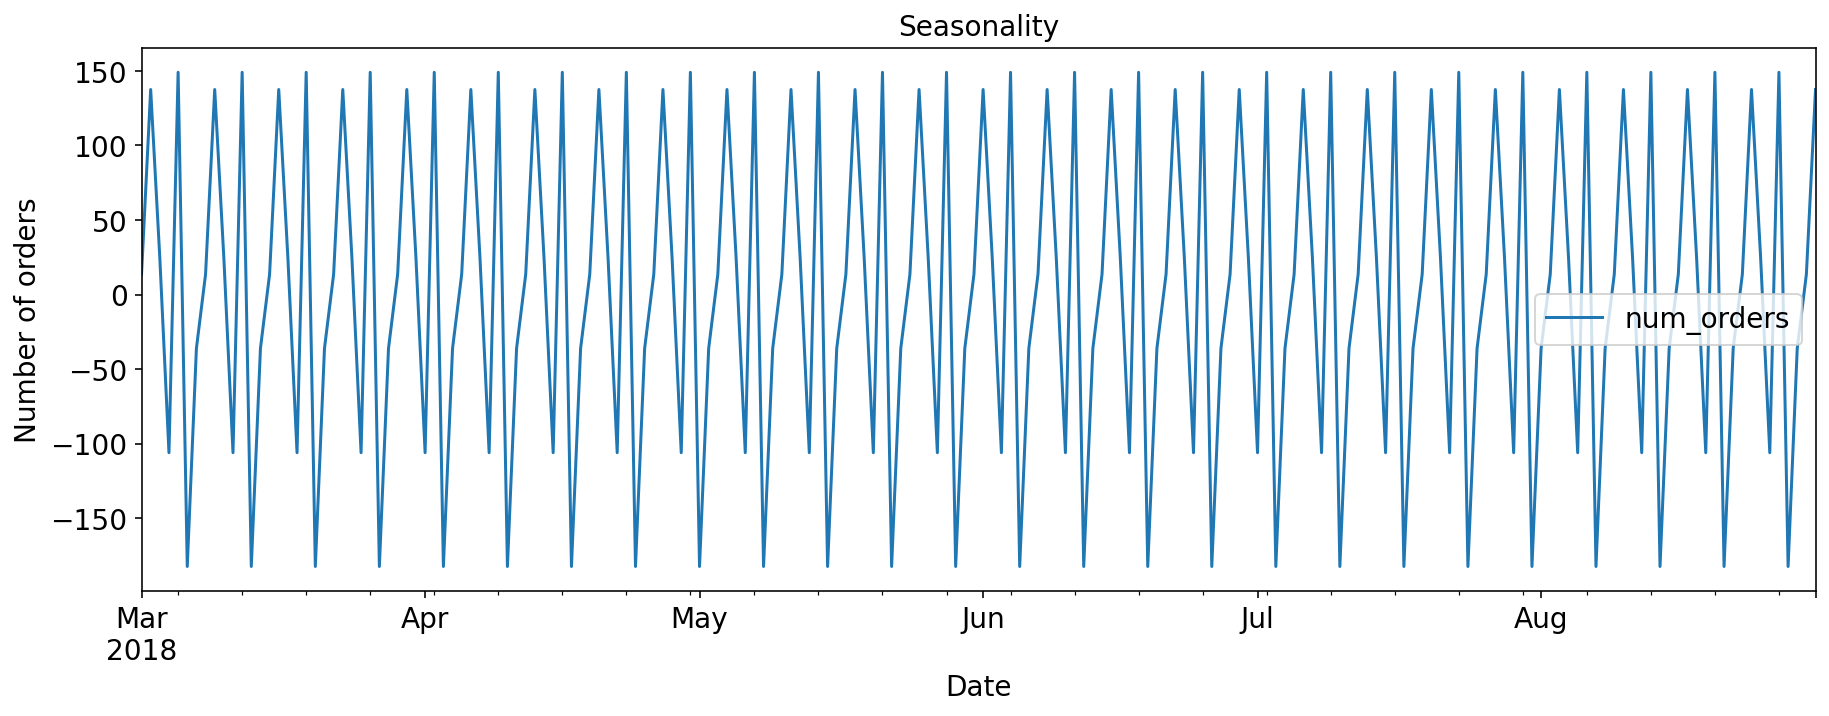

In [45]:
plt.figure(figsize=(15, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel("Date")
plt.ylabel("Number of orders")
plt.show()

Seasonality is still unclear. Let us take the intervals. The first and last month

In [46]:
march_decomposed = decomposed.seasonal['2018-03-01': '2018-03-31']
august_decomposed = decomposed.seasonal['2018-08-01': '2018-08-31']

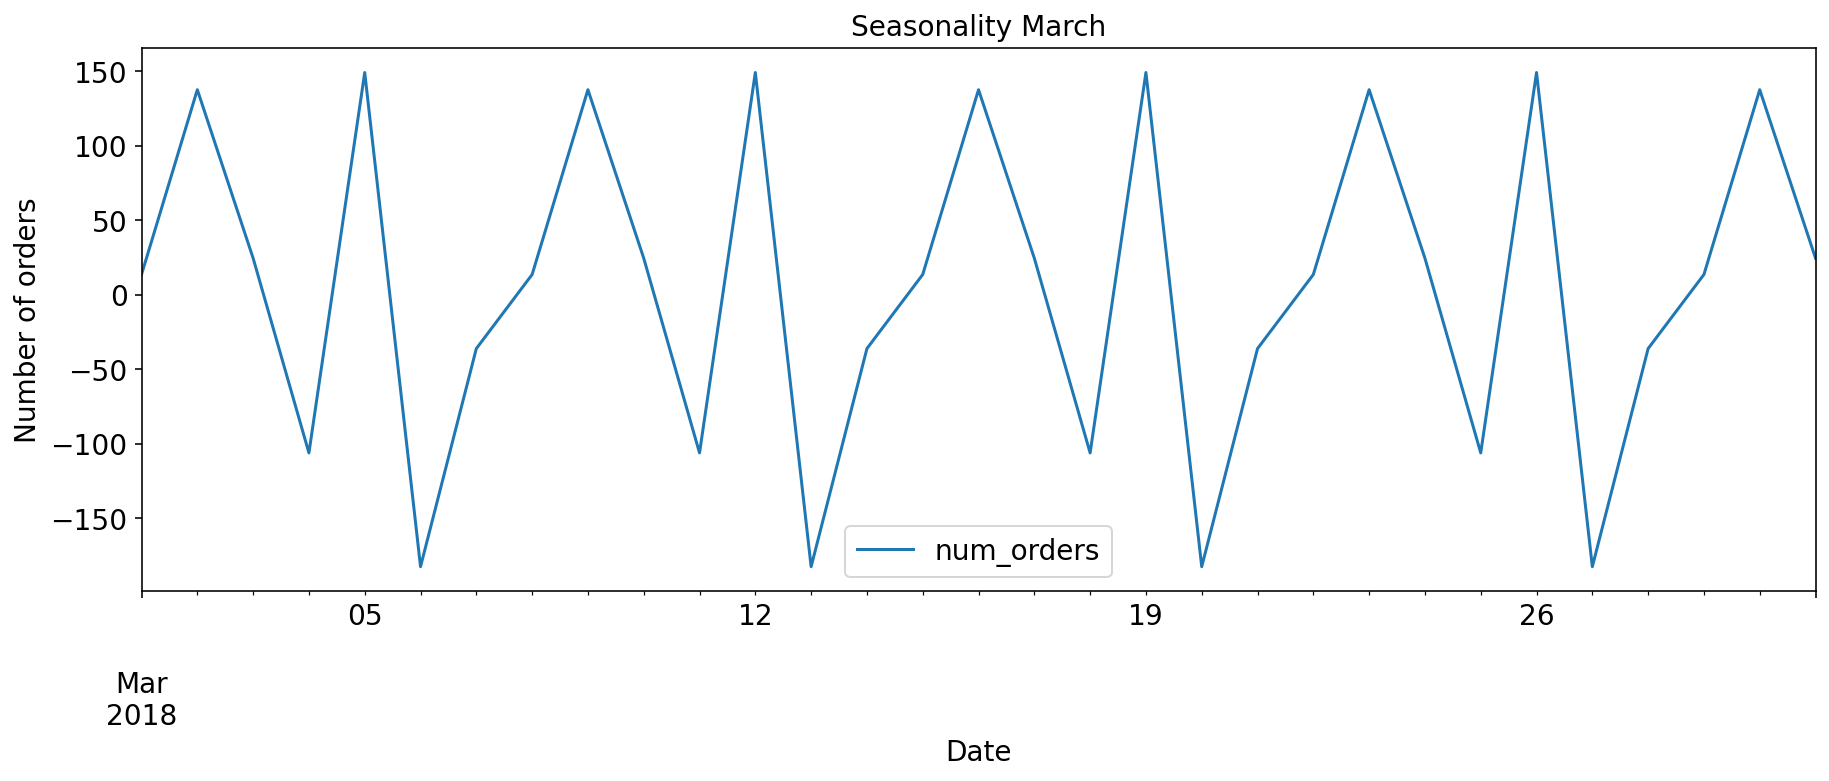

In [47]:
plt.figure(figsize=(15, 5))
march_decomposed.plot(ax=plt.gca())
plt.title('Seasonality March')
plt.xlabel("Date")
plt.ylabel("Number of orders")
plt.show()

The number of orders decreases on Mondays...

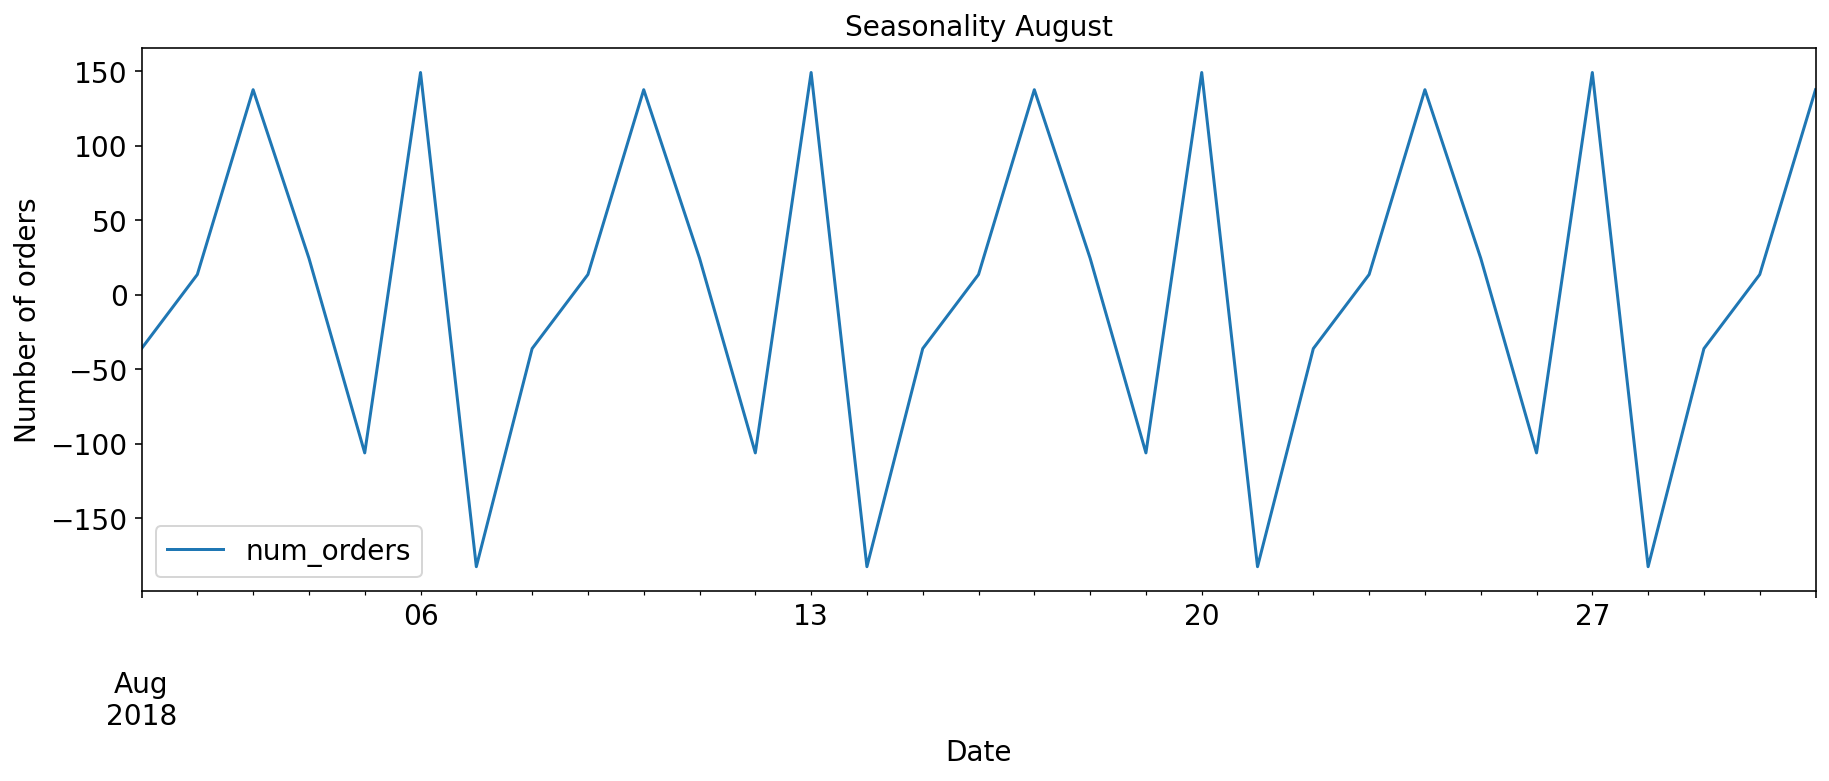

In [48]:
plt.figure(figsize=(15, 5))
august_decomposed.plot(ax=plt.gca())
plt.title('Seasonality August')
plt.xlabel("Date")
plt.ylabel("Number of orders")
plt.show()

We see the same thing on Wednesdays, the number of orders decreases.

## Summary

We analyzed the data. 

No abnormal values were found. 

Moving Average:
- In the first month, the moving average varied between 45 and 75 orders per day.
    - In the first week of March, we can see a prevailing number of orders on Saturday and Monday.
        - Saturday: most orders were at midnight. Also, the number of orders increases in the morning at 9:00 am, 3:00 pm, 8:00 pm.
        - Monday: a spike in orders at midnight. It turns out that taxi use more at night ? The number of orders increases at 12:00 noon, 6:00 pm.
    - The last week of March, a large number of orders are on Monday. 
        - Monday: The number of orders increases at 10:00-11:00 am, 3:00-16:00 pm, and 10:00-23:00 pm.
- We have found a trend - people often order taxi at night. 
    - In the last month, the range at the moving average increased from 100 to 200 orders per day.
        - First week of last month: a spike in orders on Saturday and Monday.
        - Saturday: The number of orders increases in the evening. 
- The number of orders increases in the evening and on Monday.
    - Last week: The greatest number of orders is on Monday.
        - Monday: people use taxi in the morning 09:00-10:00 hours, at lunchtime (14:00-15:00), and in the evening 22:00-23:00

Looking at the data for the first and last month, I have a hypothesis: taxi are often used in the evening ,and at night and afternoon: Monday and Saturday.

Trend:
- We see that our number of taxi orders is increasing. However, it is hard to see if we have a monthly trend, since we have data in short period of time.

Seasonality:
- We have  daily seasonality - weekdays and weekends have different number of orders

<a id="featureEngineering"></a>
# Stage 4 - Feature Engineering

Let's extract features from time series for prediction. Let's add the following features: 
1. Calendar 
2. lagging values
3. Moving average

In [49]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Feature creation function for time series.
    data - dataframe (sample)
    max_lag - maximum lag
    rolling_mean_size - window width
    """
    # Calendar features.
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['hour'] = data.index.hour
    
    # Lagging values
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Moving average
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [50]:
make_features(taxi, 1, 24)

In [51]:
taxi.head()

num_orders  dayofweek  ...   lag_1  rolling_mean
datetime                                    ...                      
2018-03-01 00:00:00         124          3  ...     nan           nan
2018-03-01 01:00:00          85          3  ... 124.000           nan
2018-03-01 02:00:00          71          3  ...  85.000           nan
2018-03-01 03:00:00          66          3  ...  71.000           nan
2018-03-01 04:00:00          43          3  ...  66.000           nan

[5 rows x 6 columns]

## Data separation

We need to check the accuracy of the model. Thus, we have to spit data into 2 samples in ratio (*90/10*): training, test samples

In [52]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [53]:
train = train.dropna()
test = test.dropna()

Write a function for target and features separation.

In [54]:
def target_features_split(data,column):
    """
    Function separates target and features. It returns 1) target, 2) features
    data - data that needs to be splitted 
    column - target 
    """
    return data[column], data.drop(column,axis=1)

In [55]:
target_train, features_train = target_features_split(train, 'num_orders')
target_test, features_test = target_features_split(test, 'num_orders')

## Summary

We have added attributes: 
1. Calendar 
2. lagging values
3. Moving average.

Also, we divided the general sample into two samples in the ratio (*90/10*): training, test. Separated the target.

<a id="MLmodelResearch"></a>
# Stage 5 - Machine Learning model research

We will explore different regression models: Linear Regression, Decision Tree, Random Forest. We will also look at boosting models.  We will check the value of metrics: RMSE,MAPE

We will keep track of machine learning models. We will create a list of models using a dictionary. Then from the dictionary we will convert the model table with all the metrics. 

In [56]:
ml_models_stats = dict()

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Write a function for model evaluation

In [58]:
def evaluate_model(model_name, model, train_features, train_target, test_features, test_target,parameters=None):
    """
    Function evaluates model with RMSE, MAPE metrics, and adds model to the table with metrics
    model_name
    model 
    train_features - features training sample
    train_target - target training sample
    test_features - features test sample
    test_target - target test sample
    parameters 
    """
    print(f'Evaluation of the model: {model_name}')
    if parameters:
        print(f'with parameters: {parameters}')
    print()
    # Generate predictions
    predicted_test = model.predict(test_features)
    predicted_train = model.predict(train_features)
    # MSE 
    mse_test = mean_squared_error(test_target, predicted_test)
    mse_train = mean_squared_error(train_target, predicted_train)
    # MAPE 
    mape_test = mean_absolute_percentage_error(predicted_test, test_target)
    mape_train = mean_absolute_percentage_error(predicted_train, train_target)
    # RMSE 
    rmse_test = mse_test ** 0.5
    rmse_train = mse_train ** 0.5
    # Display metric scores
    print(f'RMSE test: {rmse_test}')
    print(f'RMSE train: {rmse_train}')
    print(f'MAPE test: {mape_test}')
    print(f'MAPE train: {mape_train}')
    plotModelResults(model,train_features, train_target, test_features, test_target,True,False)
    # Add model
    ml_models_stats[model_name] = {
        'name': model_name,
        'rmse_train':rmse_train,
        'rmse_test':rmse_test,
        'mape_train':mape_train,
        'mape_test':mape_test
    }
    print()
    print('Model has been successfully added!')

In [59]:
def plotModelResults(model, X_train, Y_train ,X_test, Y_test,plot_intervals=False, plot_anomalies=False):
    """
        Display model results
        model 
        X_train - features train sample
        Y_train - target train sample
        X_test - features test sample
        Y_test - target test sample
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(Y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, Y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(Y_test))
            anomalies[Y_test<lower] = Y_test[Y_test<lower]
            anomalies[Y_test>upper] = Y_test[Y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, Y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [60]:
random_state_val = 42

## Linear Regression

In [61]:
%%time
clf = LinearRegression()
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False]}

tscv = TimeSeriesSplit(n_splits=8)
linear_grid_search = GridSearchCV(clf, param_grid, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs= -1)
linear_grid_search = linear_grid_search.fit(features_train, target_train)

CPU times: user 209 ms, sys: 48.5 ms, total: 257 ms
Wall time: 1.64 s


Evaluation of the model: Linear Regression
with parameters: {'fit_intercept': False, 'normalize': True}

RMSE test: 51.107134762711816
RMSE train: 30.869934811680107
MAPE test: 29.05696218946995
MAPE train: 31.56283798043198

Model has been successfully added!


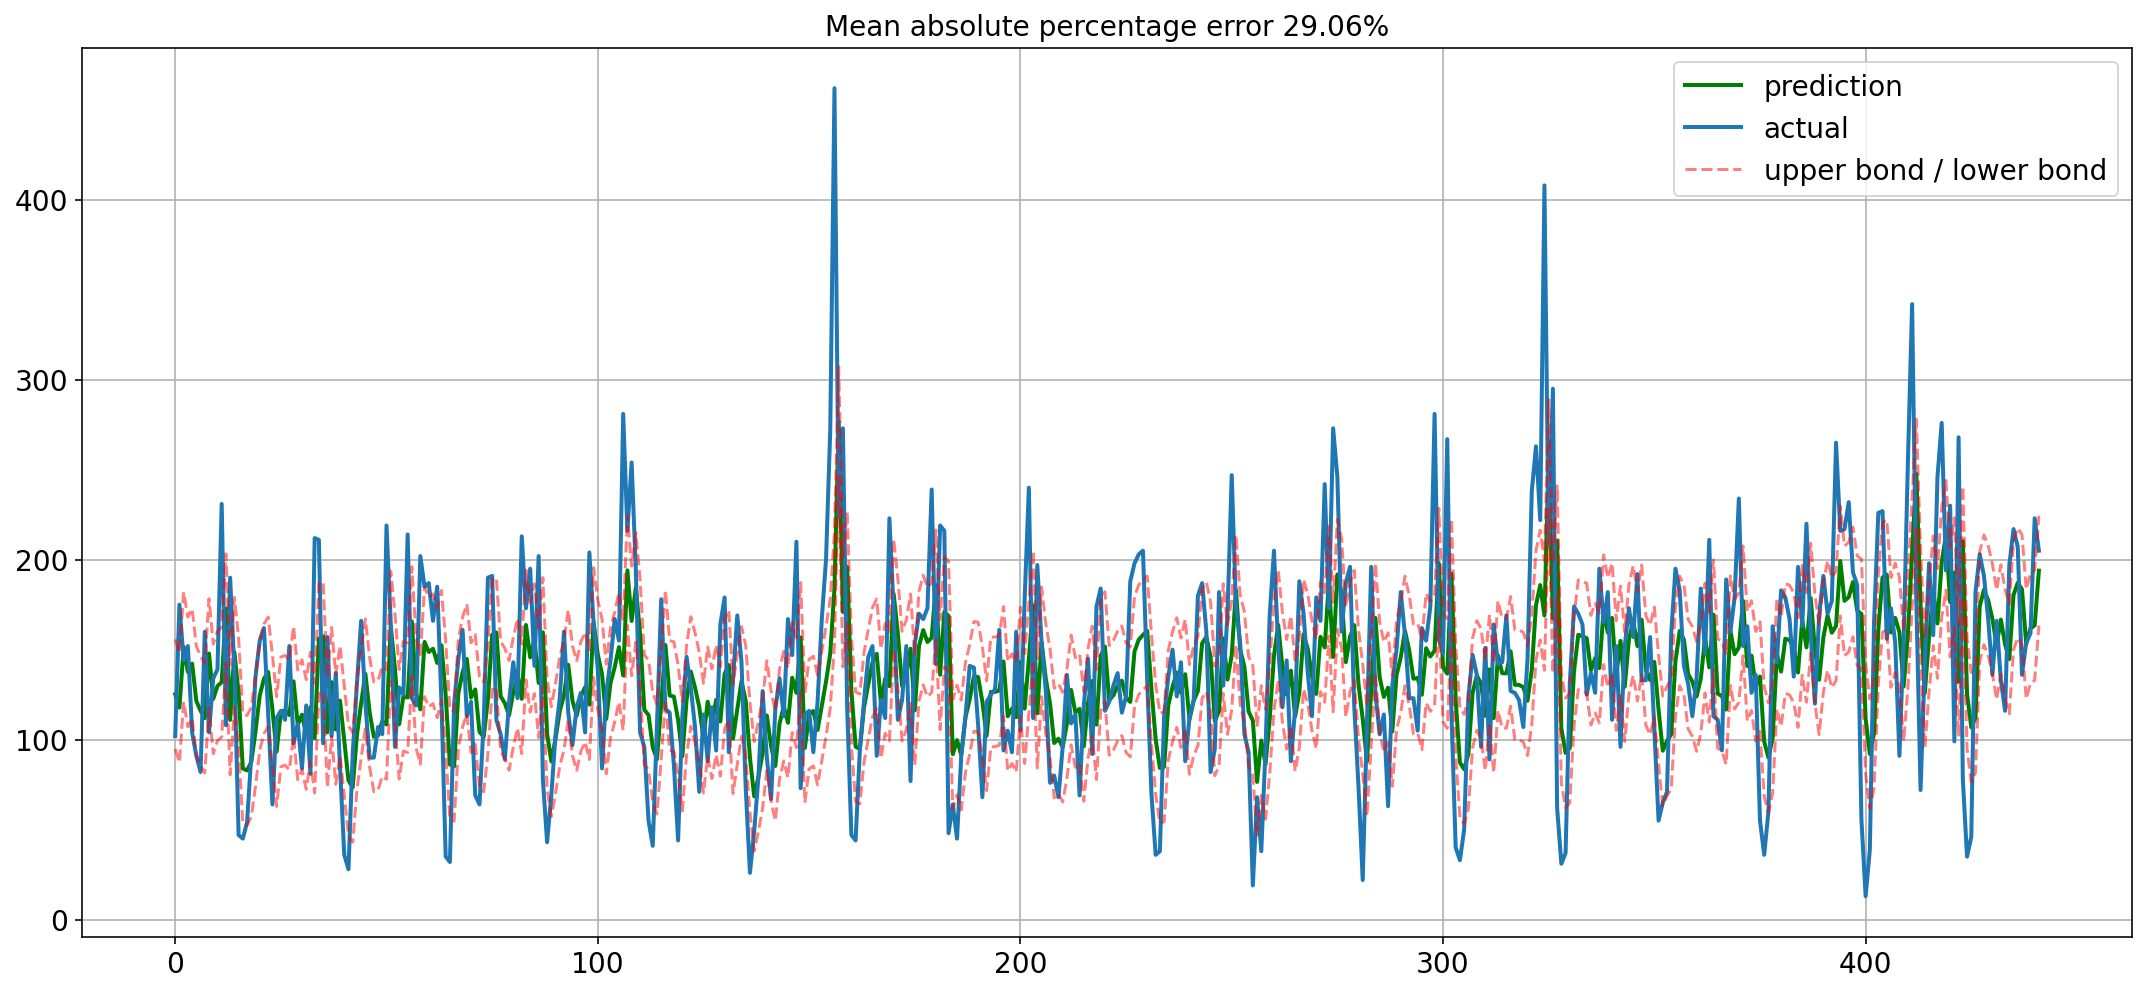

In [62]:
evaluate_model("Linear Regression", linear_grid_search.best_estimator_, features_train, target_train, features_test, target_test,linear_grid_search.best_params_)

The RMSE of Linear Regression is 52.65. The model is wrong by 52 orders on average. MAPE - the model is wrong by 33%.

## ElasticNet

In [63]:
%%time
clf = ElasticNet()
param_grid = {'alpha':[10,100,1000,10000], 'l1_ratio':[0, 0.25, 0.5, 0.75,1],'fit_intercept':[True,False], 'normalize':[True,False]}
tscv = TimeSeriesSplit(n_splits=8)
elastic_grid_search = GridSearchCV(clf, param_grid, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs= -1)
elastic_grid_search = elastic_grid_search.fit(features_train, target_train)

CPU times: user 683 ms, sys: 18.4 ms, total: 701 ms
Wall time: 3.71 s


Evaluation of the model: ElasticNet
with parameters: {'alpha': 10, 'fit_intercept': False, 'l1_ratio': 1, 'normalize': True}

RMSE test: 51.035152538857616
RMSE train: 30.936595027053617
MAPE test: 28.718295582456303
MAPE train: 31.886967311412977

Model has been successfully added!


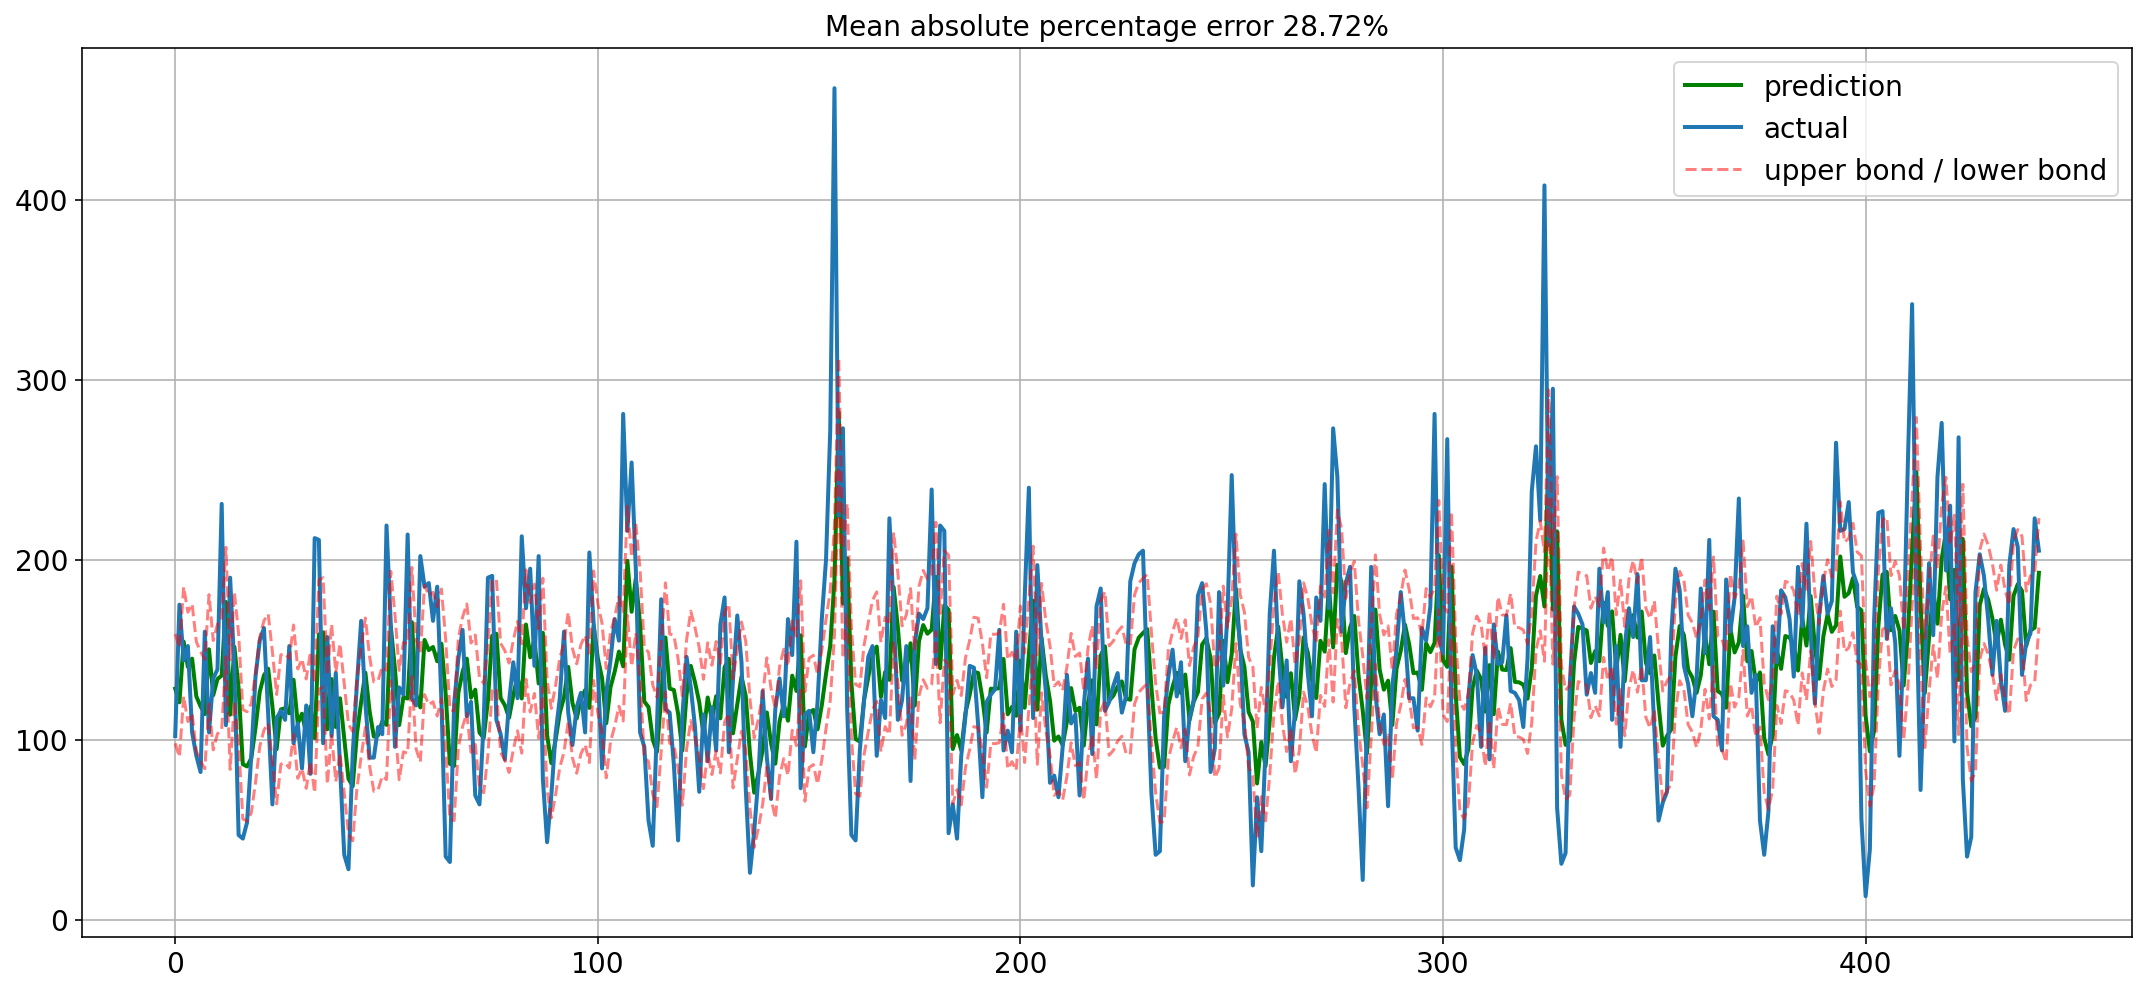

In [64]:
evaluate_model("ElasticNet", elastic_grid_search.best_estimator_, features_train, target_train, features_test, target_test, elastic_grid_search.best_params_)

The results are slightly worse on the RMSE metric - 52.75. The model is 33% wrong

## Decision Tree

In [65]:
%%time
clf = DecisionTreeRegressor()
param_grid = {'max_depth': range(1,30), 'min_samples_leaf': range(1,30)}
tscv = TimeSeriesSplit(n_splits=8)
decision_grid_search = GridSearchCV(clf, param_grid, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs= -1)
decision_grid_search = decision_grid_search.fit(features_train, target_train)

CPU times: user 5.79 s, sys: 135 ms, total: 5.93 s
Wall time: 39.1 s


Evaluation of the model: Decision Tree
with parameters: {'max_depth': 22, 'min_samples_leaf': 10}

RMSE test: 49.72317893909049
RMSE train: 20.157220367244086
MAPE test: 34.84401991083002
MAPE train: 20.768910262682827

Model has been successfully added!


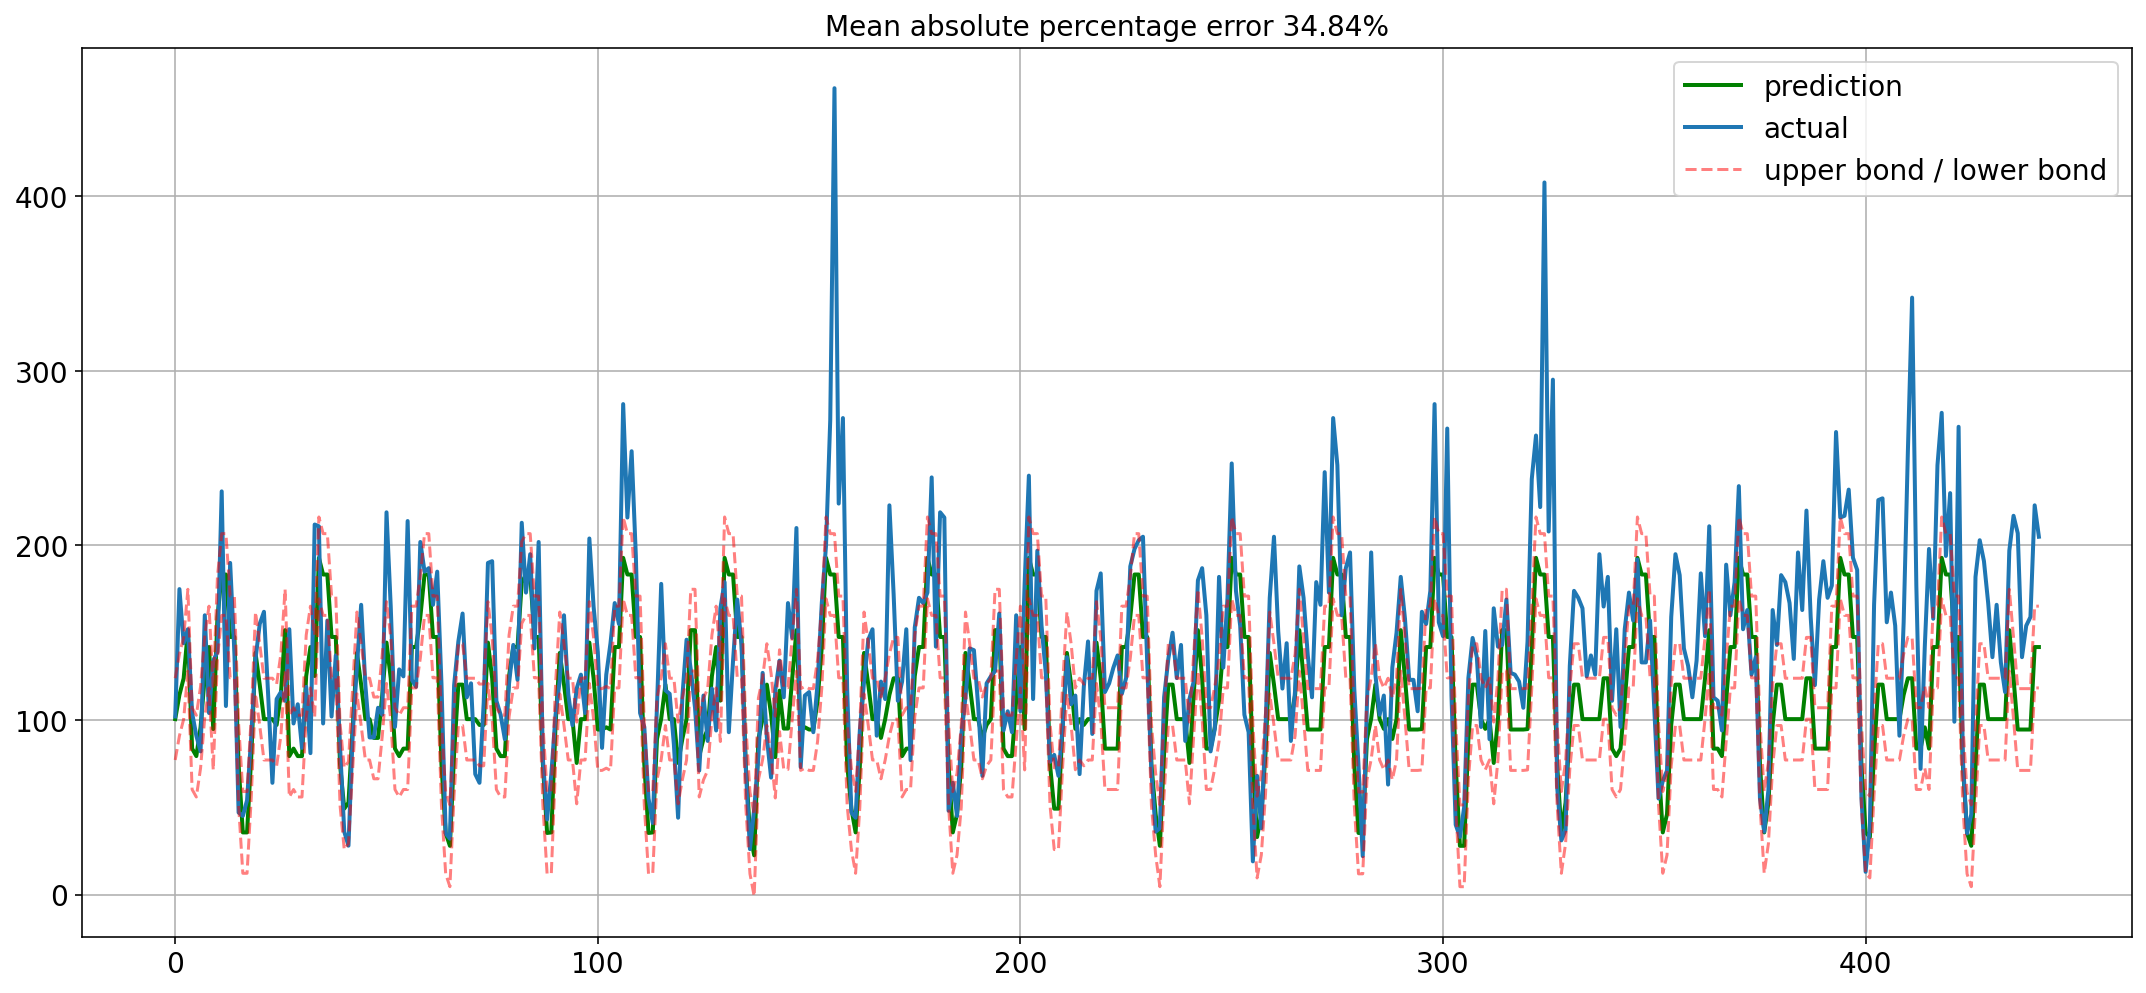

In [66]:
evaluate_model("Decision Tree",decision_grid_search.best_estimator_ , features_train, target_train, features_test, target_test, decision_grid_search.best_params_)

The decision tree has a better result. The model is wrong on 46 orders on average, 29%.

## Random Forest

In [67]:
%%time
clf = RandomForestRegressor()
param_grid = {'n_estimators': range(1,61,10), 'max_depth': range(1,30)}
tscv = TimeSeriesSplit(n_splits=8)
forest_grid_search = GridSearchCV(clf, param_grid, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs= -1)
forest_grid_search = forest_grid_search.fit(features_train, target_train)

CPU times: user 6.05 s, sys: 256 ms, total: 6.3 s
Wall time: 2min 24s


Evaluation of the model: Random Forest
with parameters: {'max_depth': 12, 'n_estimators': 31}

RMSE test: 45.23945639923339
RMSE train: 13.084091821573223
MAPE test: 28.167840750616126
MAPE train: 13.960663973322976

Model has been successfully added!


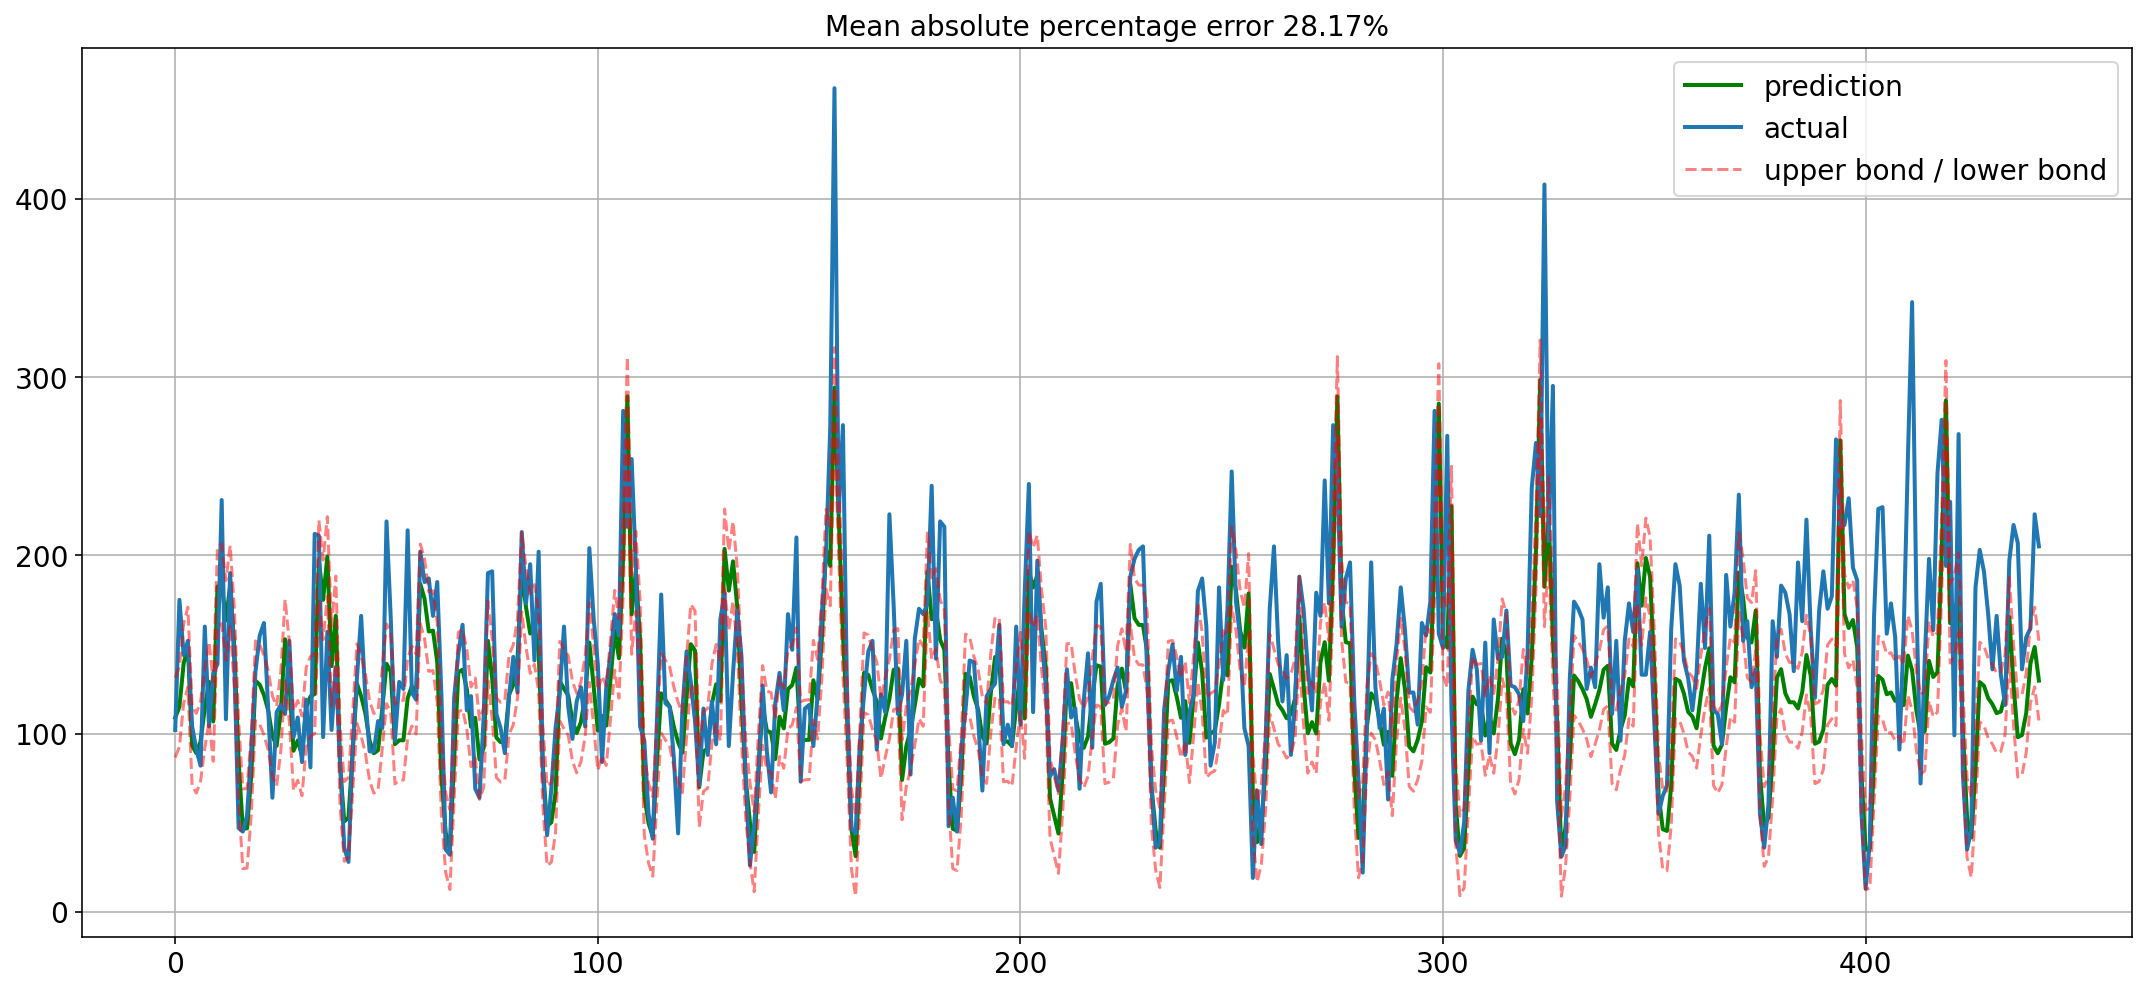

In [68]:
evaluate_model("Random Forest", forest_grid_search.best_estimator_, features_train, target_train, features_test, target_test, forest_grid_search.best_params_)

Random Forest has improved in metrics: 43% - RMSE, 27% - MAPE. Let's move on to the boostings.

## XGBoost

In [69]:
%%time
clf = xgb.XGBRegressor()
param_grid = {"max_depth": range(3, 20,2),"min_child_weight": range(1,24,2)}
tscv = TimeSeriesSplit(n_splits=8)
xgb_grid_search = GridSearchCV(clf, param_grid, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs= -1)
xgb_grid_search = xgb_grid_search.fit(features_train, target_train)

[05:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6.76 s, sys: 320 ms, total: 7.08 s
Wall time: 2min 56s


Evaluation of the model: XGBoost
with parameters: {'max_depth': 5, 'min_child_weight': 23}

RMSE test: 44.020320625659345
RMSE train: 18.97496488490014
MAPE test: 27.793767947447034
MAPE train: 20.292081337786485
[05:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:57] WARNING: /work

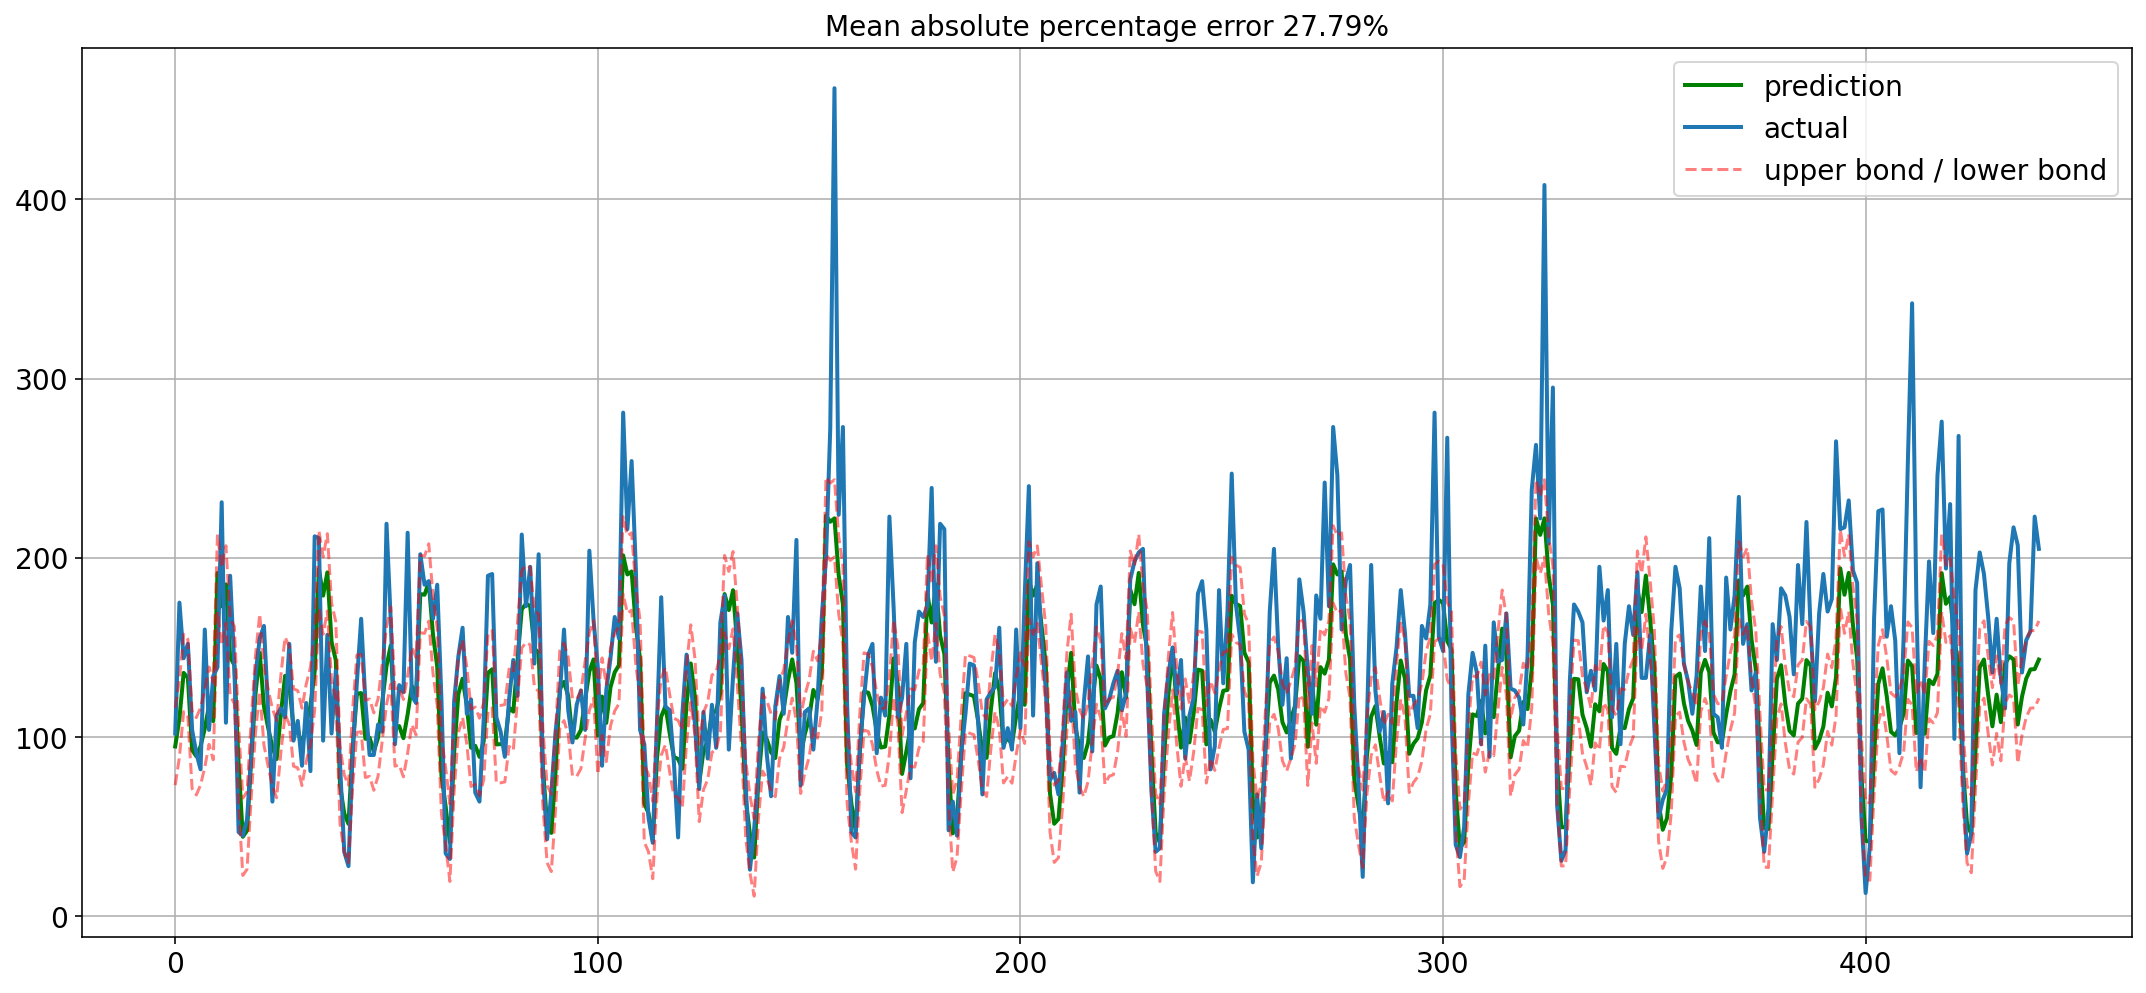

In [70]:
evaluate_model("XGBoost", xgb_grid_search.best_estimator_, features_train, target_train, features_test, target_test, xgb_grid_search.best_params_)

XGBoost show lower metric scores than Random Forest. RMSE - 44.93. MAPE - 28%.

## LightGBM

In [71]:
%%time
clf = lgb.LGBMRegressor()
param_grid = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': range(1,30,5),
    'num_leaves': [10,200,250]
}
tscv = TimeSeriesSplit(n_splits=8)
lgb_grid_search = GridSearchCV(clf, param_grid, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs= -1)
lgb_grid_search = lgb_grid_search.fit(features_train, target_train)

CPU times: user 2.53 s, sys: 89.1 ms, total: 2.62 s
Wall time: 49.3 s


Evaluation of the model: LightGBM
with parameters: {'boosting_type': 'gbdt', 'max_depth': 6, 'num_leaves': 200, 'objective': 'regression'}

RMSE test: 43.105198789309775
RMSE train: 17.857587111133576
MAPE test: 26.85681982561434
MAPE train: 19.09934355793816

Model has been successfully added!


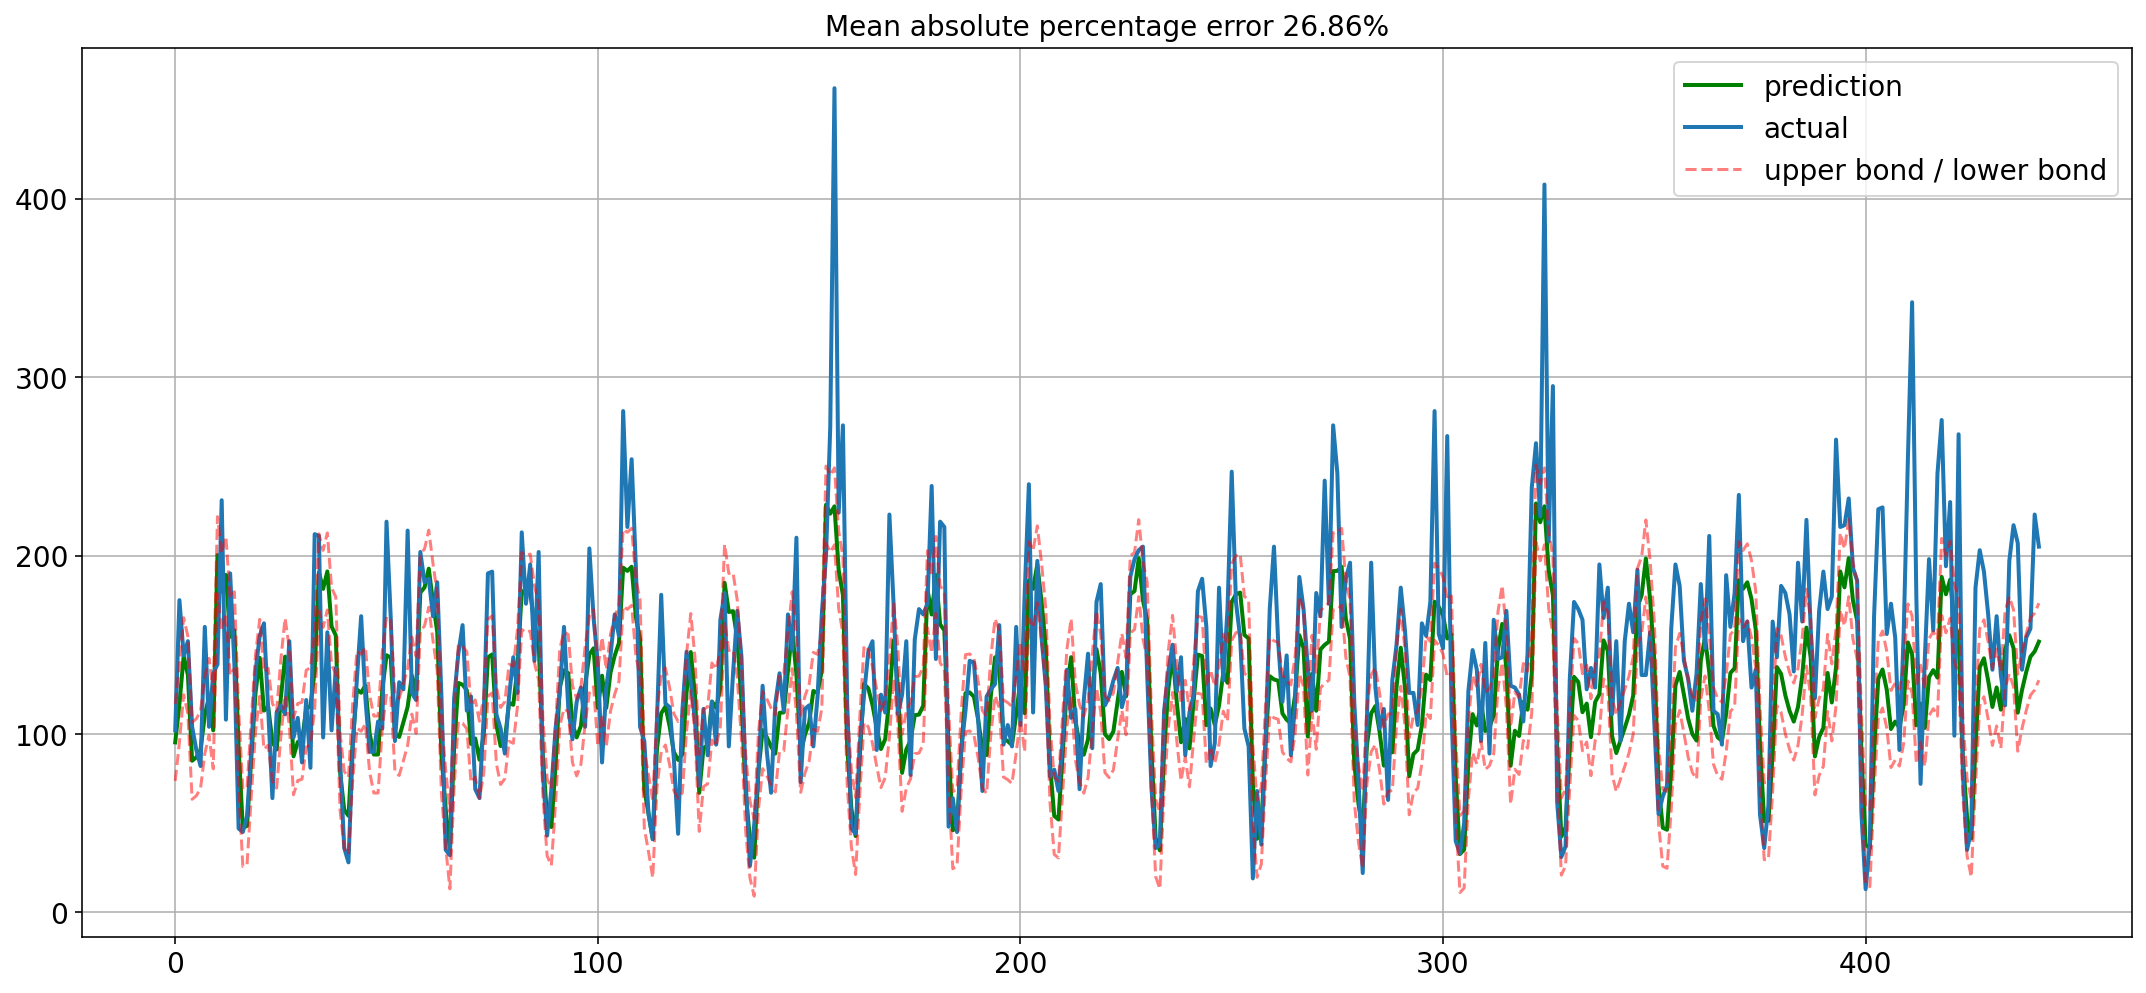

In [72]:
evaluate_model("LightGBM", lgb_grid_search.best_estimator_, features_train, target_train, features_test, target_test,lgb_grid_search.best_params_)

The model showed good results on metrics. Errors by 42 orders on average - RMSE. 26% - MAPE.

## Dummy

In [73]:
# create model
dummy_model = DummyRegressor(strategy="constant", constant=target_train.median())
# train model
dummy_model.fit(features_train,target_train)

DummyRegressor(constant=array(75.), quantile=None, strategy='constant')

Evaluation of the model: Dummy constant

RMSE test: 87.15277582981295
RMSE train: 38.833872073914605
MAPE test: 94.38914027149315
MAPE train: 39.61552742616026

Model has been successfully added!


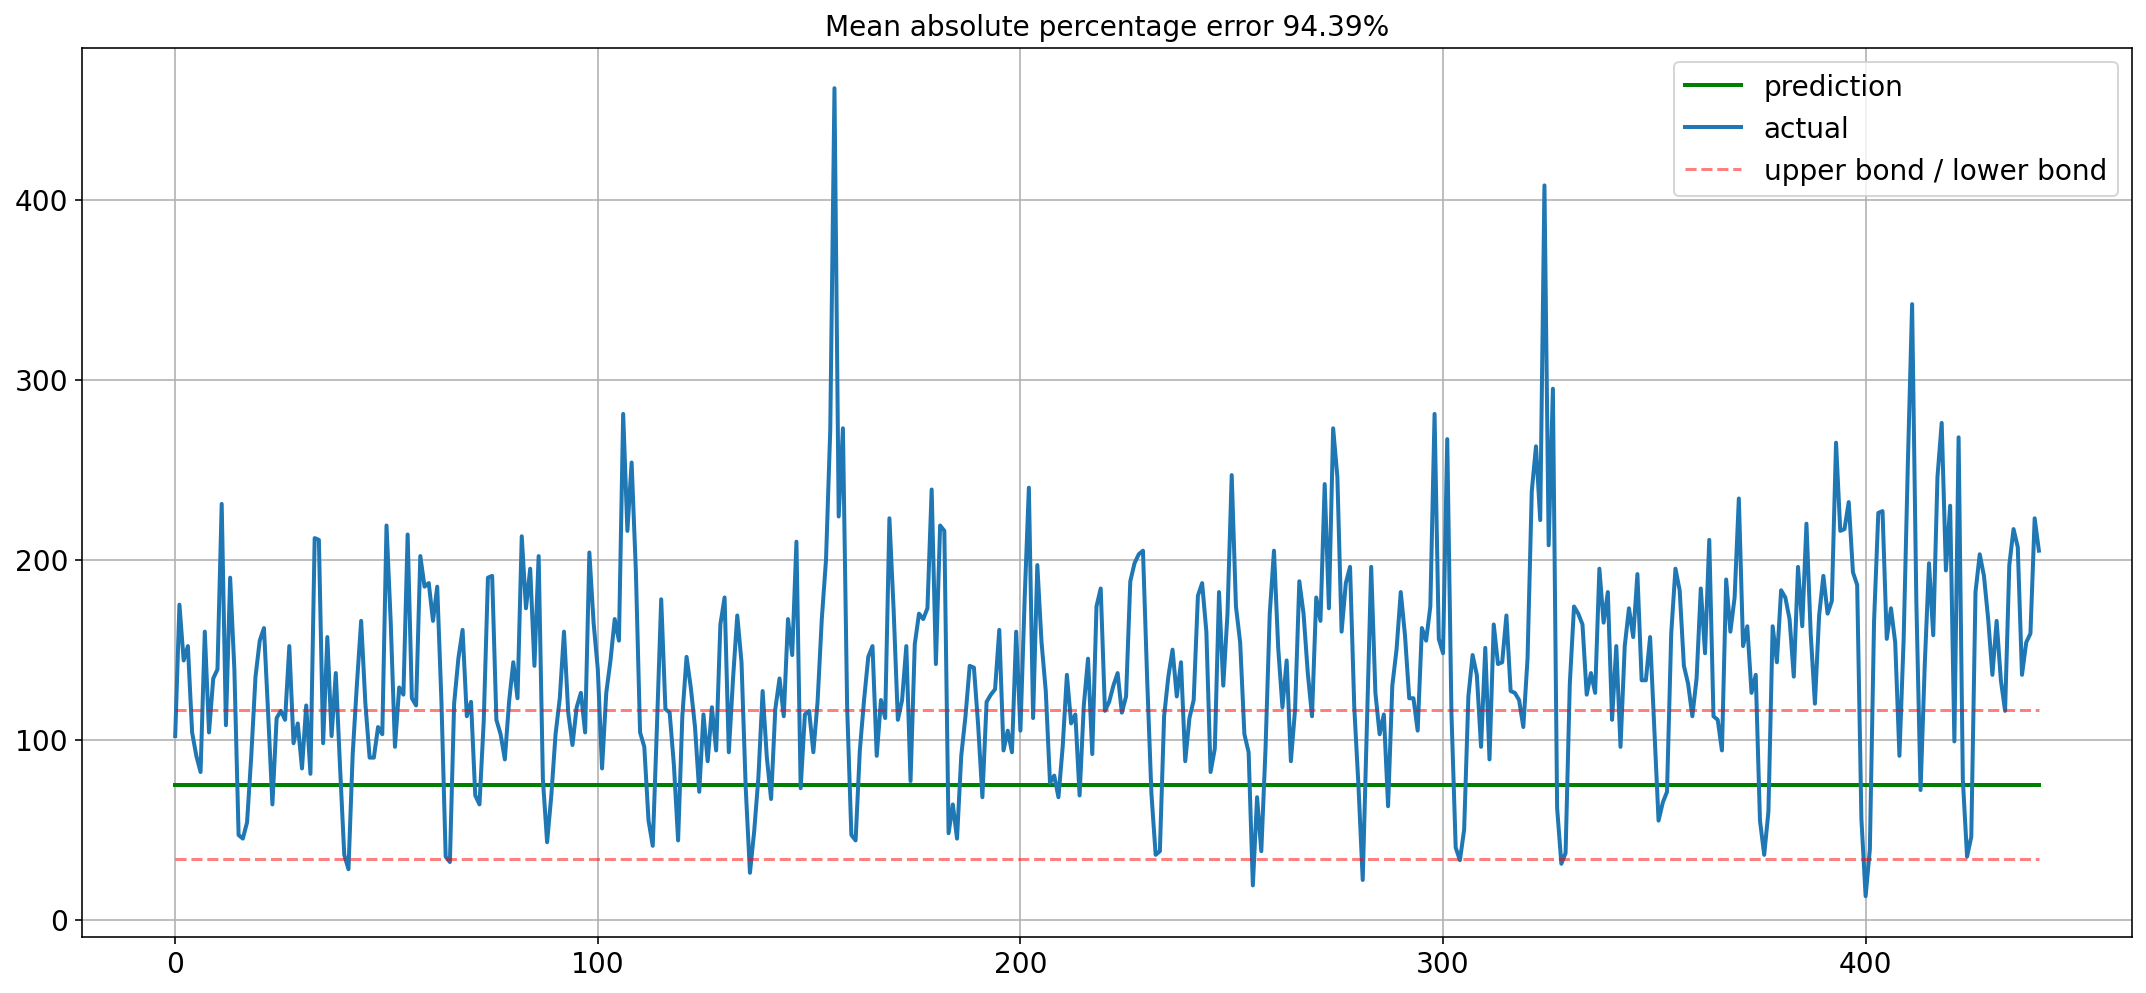

In [74]:
evaluate_model('Dummy constant', dummy_model, features_train, target_train, features_test, target_test)

## Previous value of time series

In [75]:
pred_previous = target_test.shift()

In [76]:
pred_previous.iloc[0] = target_train.iloc[-1]

In [77]:
mse_previous = mean_squared_error(target_test, pred_previous)
mape_previous = mean_absolute_percentage_error(mse_previous, target_test)
rmse_previous = mse_previous ** 0.5
print(f'RMSE the previous value on the test sample: {rmse_previous}')
print(f'MAPE the previous value on the test sample: {mape_previous}')

RMSE the previous value on the test sample: 58.856486242815066
MAPE the previous value on the test sample: 95.97133090287808


In [78]:
ml_models_stats['previous'] = {
    'name': 'previous',
    'rmse_train':None,
    'rmse_test':rmse_previous,
    'mape_train':None,
    'mape_test':mape_previous
}

## Summary

We have explored machine learning models. Let's move on to the results. 

<a id="resultsRearchModel"></a>
# Stage 6 - Research results

At this stage we must analyze the quality of the models.

The RMSE metric is important for business. The RMSE should not be 48.

Let's write an additional function to display the graphs

In [79]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Function for plotting graphs 
    df - dataframe
    x_axis
    y_axis
    x_label - label for x axis
    y_label - label for y axis
    plot_title - title 
    order - column by which the order will be determined 
    """
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Create the table from the models dictionary

In [80]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

name  rmse_train  rmse_test  mape_train  mape_test
0  Linear Regression      30.870     51.107      31.563     29.057
1         ElasticNet      30.937     51.035      31.887     28.718
2      Decision Tree      20.157     49.723      20.769     34.844
3      Random Forest      13.084     45.239      13.961     28.168
4            XGBoost      18.975     44.020      20.292     27.794
5           LightGBM      17.858     43.105      19.099     26.857
6     Dummy constant      38.834     87.153      39.616     94.389
7           previous         nan     58.856         nan     95.971

Models that have passed sanity check.

In [81]:
approved_models = ml_models.query("rmse_test < 87")
approved_models

name  rmse_train  rmse_test  mape_train  mape_test
0  Linear Regression      30.870     51.107      31.563     29.057
1         ElasticNet      30.937     51.035      31.887     28.718
2      Decision Tree      20.157     49.723      20.769     34.844
3      Random Forest      13.084     45.239      13.961     28.168
4            XGBoost      18.975     44.020      20.292     27.794
5           LightGBM      17.858     43.105      19.099     26.857
7           previous         nan     58.856         nan     95.971

All models have passed sanity check

Filter out those models whose RMSE metrics do not meet the business requirement. RMSE < 48

In [82]:
business_approved_models = approved_models.query("rmse_test < 48")
business_approved_models

name  rmse_train  rmse_test  mape_train  mape_test
3  Random Forest      13.084     45.239      13.961     28.168
4        XGBoost      18.975     44.020      20.292     27.794
5       LightGBM      17.858     43.105      19.099     26.857

Models that passed test: Random Forest, XGBoost, LightGBM

Find the best model according to the RMSE metric on the test sample

name  rmse_test
0       LightGBM     43.105
1        XGBoost     44.020
2  Random Forest     45.239

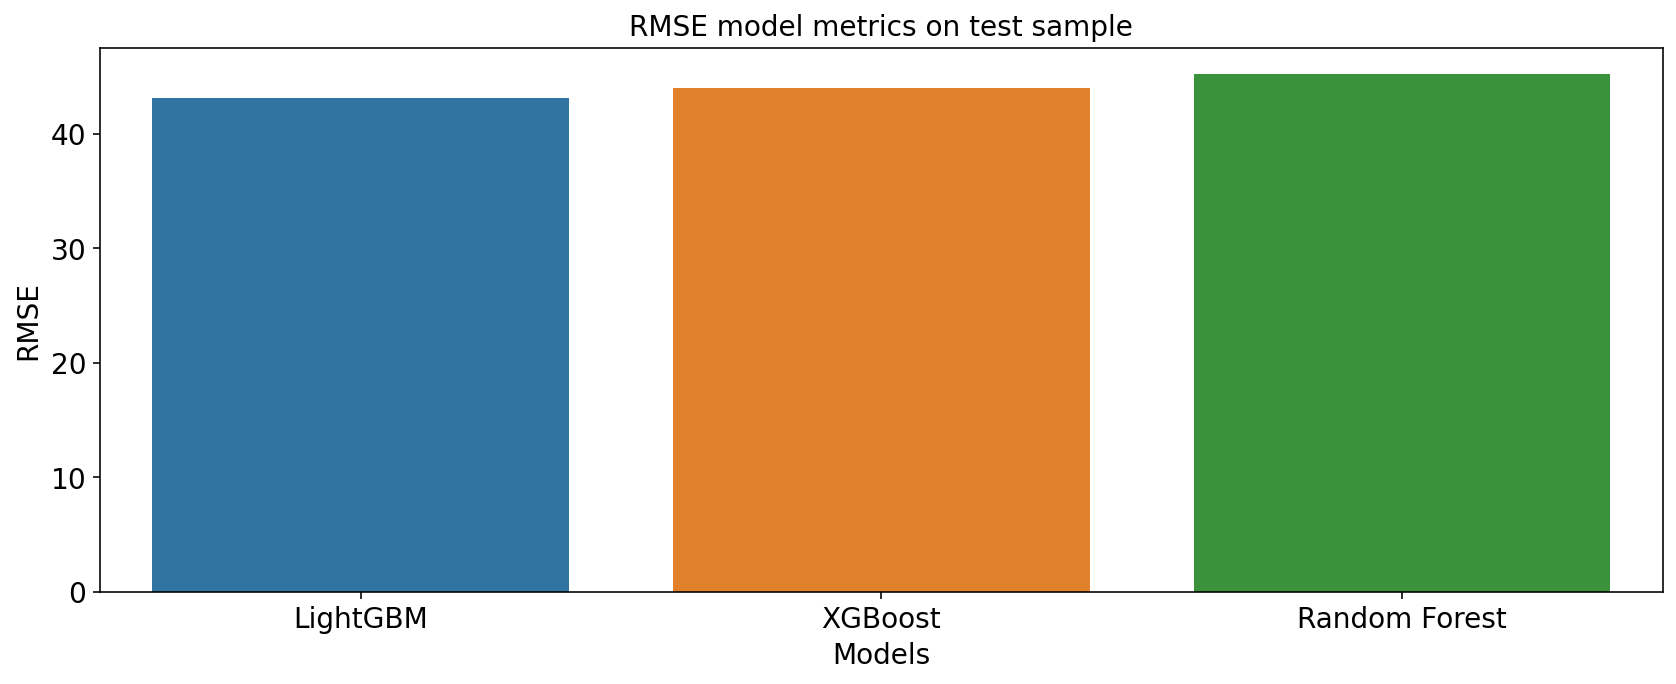

In [84]:
rmse_test_sorted = business_approved_models.sort_values(by='rmse_test',ascending=True).reset_index()
display(rmse_test_sorted[['name','rmse_test']])
drawPlot(rmse_test_sorted, 'name','rmse_test','Models','RMSE','RMSE model metrics on test sample','name' )

LightGBM model showed the best score - 43.105. 

Let's find the best model according to MAPE metrics

name  mape_test
0       LightGBM     26.857
1        XGBoost     27.794
2  Random Forest     28.168

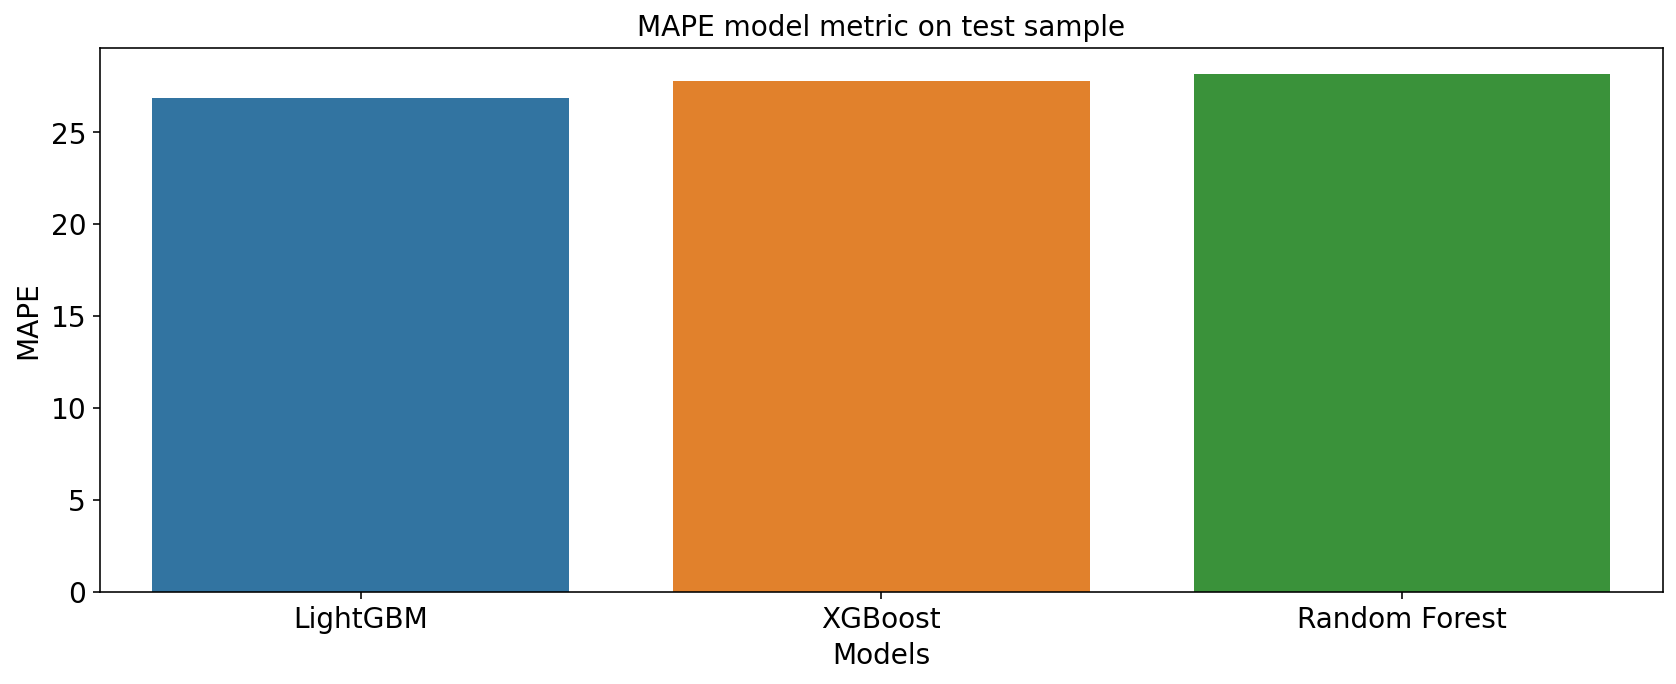

In [85]:
mape_test_sorted = business_approved_models.sort_values(by='mape_test',ascending=True).reset_index()
display(mape_test_sorted[['name','mape_test']])
drawPlot(mape_test_sorted, 'name','mape_test','Models','MAPE','MAPE model metric on test sample','name' )

LightGBM has a good MAPE score - 27%. 

Based on the results and graphs obtained, we choose the best model - **LightGBM**. The model has a good scores on two metrics RMSE, MAPE.

<a id="results"></a>
# Stage 7 - Results

In the project we successfully built Machine Learning models to predict the number of taxi orders for the next hour.  We chose the best model that meets the business requirement. In the project we did:

### Data Preprocessing

We resampled the data by one hour at a time. 

The data passed the final check. 

### Data Analysis

No abnormal values were found. 

Moving Average:
- In the first month, the moving average varied between 45 and 75 orders per day.
    - In the first week of March, we can see a prevailing number of orders on Saturday and Monday.
        - Saturday: most orders were at midnight. Also, the number of orders increases in the morning at 9:00 am, 3:00 pm, 8:00 pm.
        - Monday: a spike in orders at midnight. It turns out that taxi use more at night ? The number of orders increases at 12:00 noon, 6:00 pm.
    - The last week of March, a large number of orders are on Monday. 
        - Monday: The number of orders increases at 10:00-11:00 am, 3:00-16:00 pm, and 10:00-23:00 pm.
- We have found a trend - people often order taxi at night. 
    - In the last month, the range at the moving average increased from 100 to 200 orders per day.
        - First week of last month: a spike in orders on Saturday and Monday.
        - Saturday: The number of orders increases in the evening. 
- The number of orders increases in the evening and on Monday.
    - Last week: The greatest number of orders is on Monday.
        - Monday: people use taxi in the morning 09:00-10:00 hours, at lunchtime (14:00-15:00), and in the evening 22:00-23:00

Looking at the data for the first and last month, I have a hypothesis: taxi are often used in the evening ,and at night and afternoon: Monday and Saturday.

Trend:
- We see that our number of taxi orders is increasing. However, it is hard to see if we have a monthly trend, since we have data in short period of time.

Seasonality:
- We have  daily seasonality - weekdays and weekends have different number of orders

### Feature Engineering

We have added attributes: 
1. Calendar 
2. lagging values
3. Moving average.

Also, we divided the general sample into two samples in the ratio (*90/10*): training, test. Separated the target.

### Machine Learning models research

- We checked 6 machine learning models (*Linear Regression*,*ElasticNet* *Decision Tree*, *Random Forest*, *XGBoost*, *LightGBM*).
- RMSE: The LightGBM model is the best indicator - 43.105.
- MAPE: The LightGBM has a good MAPE - 27%.

Based on the results and graphs obtained, we choose the best model - **LightGBM**. The model has a good scores on two metrics RMSE, MAPE.